<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>
<h1> Signal Purification </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import ipython_memory_usage

import warnings
warnings.filterwarnings("ignore")

%ipython_memory_usage_start

'memory profile enabled'

In [1] used 0.0742 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 119.73 MiB


Считывание файла с данными. Он очень большой!

In [2]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 1min 22s
In [2] used 1778.4961 MiB RAM in 82.84s, peaked 1859.13 MiB above current, total RAM usage 1898.23 MiB


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [3]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


In [3] used -1121.5000 MiB RAM in 1.85s, peaked 10.75 MiB above current, total RAM usage 654.96 MiB


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [4]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


In [4] used 3.0312 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 657.99 MiB


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 7min 59s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 29s


Посмотрим теперь на распределение секторов среди тикеров.

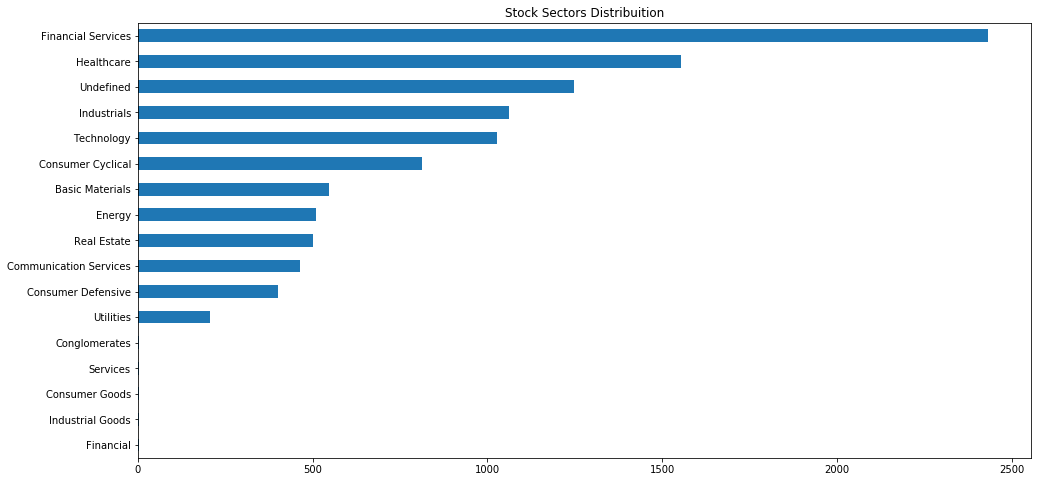

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [3]:
num_lags = 4

MAX_FILING = pow(10,13)
MAX_SSH_PRN_AMP = pow(10, 8)
MAX_MVAL = pow(10, 10)

In [3] used 7.1602 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1905.39 MiB


Чищу данные.

In [4]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
df = df[df['ssh_prn_amt_type'] == 'SH']
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = df.ssh_prn_amt

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
mvsum = df.groupby('access_id').market_value.sum().reset_index()
df = df[(df.market_value > 0) & (df.shares > 0) & \
                (df.shares < MAX_SSH_PRN_AMP) & (df.market_value < MAX_MVAL) & \
                df.access_id.isin(mvsum[mvsum.market_value < MAX_FILING].access_id.unique())]

del mvsum

df['close'] = df.market_value.div(df.shares, axis=0)

df = df[(pd.to_datetime(df['stamp']) - pd.to_datetime(df['conformed_period_of_report']) < '250d')]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'access_id', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 24.8 s
In [4] used -1460.5898 MiB RAM in 24.93s, peaked 3965.27 MiB above current, total RAM usage 444.80 MiB


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [5]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

In [5] used 19.1016 MiB RAM in 0.44s, peaked 0.00 MiB above current, total RAM usage 462.99 MiB


Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [5]:
df = df[df.cik.isin(np.random.choice(df.cik.unique(), 1_500, replace=False))]

In [5] used -185.8164 MiB RAM in 0.64s, peaked 364.22 MiB above current, total RAM usage 258.98 MiB


In [6]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'access_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max',
                                                             'close': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()

Wall time: 3min 40s
In [6] used -4.5859 MiB RAM in 220.44s, peaked 537.30 MiB above current, total RAM usage 254.40 MiB


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [20]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers_lookup, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by ticker')

0.387% covered by ticker
In [20] used 158.4648 MiB RAM in 1.04s, peaked 129.96 MiB above current, total RAM usage 412.98 MiB


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [7]:
%%time

not_observed = df.pivot(index='period', columns=['cik', 'ticker_id'], values='shares') \
                                                .isna().unstack().reset_index(name='nid')

not_observed = not_observed[not_observed.nid]

Wall time: 1.25 s
In [7] used 105.5781 MiB RAM in 1.35s, peaked 83.55 MiB above current, total RAM usage 359.98 MiB


In [8]:
%%time

df = df.merge(not_observed, on=['cik', 'ticker_id', 'period'], how='outer', suffixes=(False, False))
del not_observed

df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

df['shares'] = df.shares.fillna(0)
df['market_value'] = df.market_value.fillna(0)

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 37.1 s
In [8] used 572.1523 MiB RAM in 37.22s, peaked 879.30 MiB above current, total RAM usage 932.13 MiB


In [9]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)

print(str(final_df.shape[0]) + ' observations for ' + str(final_df.cik.nunique()) + ' funds, '
      + str(final_df.ticker_id.nunique()) + ' tickers and ' + str(final_df.period.nunique()) + ' periods!')

5102487 observations for 1500 funds, 9880 tickers and 13 periods!
In [9] used 428.3164 MiB RAM in 0.55s, peaked 1.82 MiB above current, total RAM usage 1360.45 MiB


## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [10]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()
funds_value = funds_value[funds_value.market_value > 0]

In [10] used 0.7578 MiB RAM in 0.49s, peaked 169.54 MiB above current, total RAM usage 1361.20 MiB


Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [11]:
funds_value.head()

,period,cik,market_value
337,2015Q3,1098490,3.238080e+08
496,2015Q3,1288136,6.861300e+07
1519,2015Q4,80255,4.718400e+07
1692,2015Q4,1000275,1.651083e+10
1830,2015Q4,1093219,3.788790e+08


In [11] used 0.2539 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1361.46 MiB


Рассмотрим некоторые основные описательные статистики.

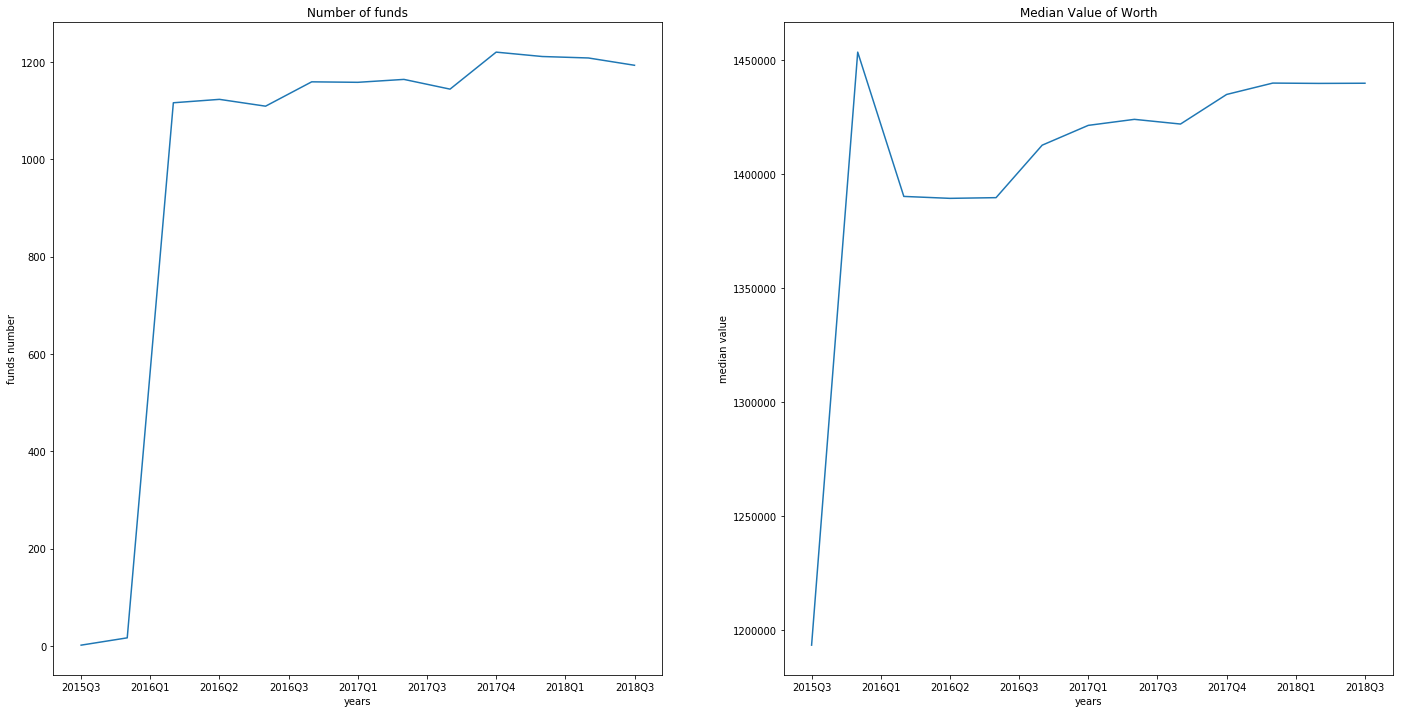

In [12] used 10.4492 MiB RAM in 0.53s, peaked 1.75 MiB above current, total RAM usage 1371.91 MiB


In [12]:
fig, axs = pl.subplots(1, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0].set_title('Number of funds');
axs[0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1].set_title('Median Value of Worth');
axs[1].set(xlabel='years', ylabel='median value');
axs[1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [13]:
final_df = final_df[final_df.period >= '2016Q1']

In [13] used -32.7969 MiB RAM in 0.71s, peaked 466.03 MiB above current, total RAM usage 1339.11 MiB


Теперь я посмотрю на распределение ценности фондов.

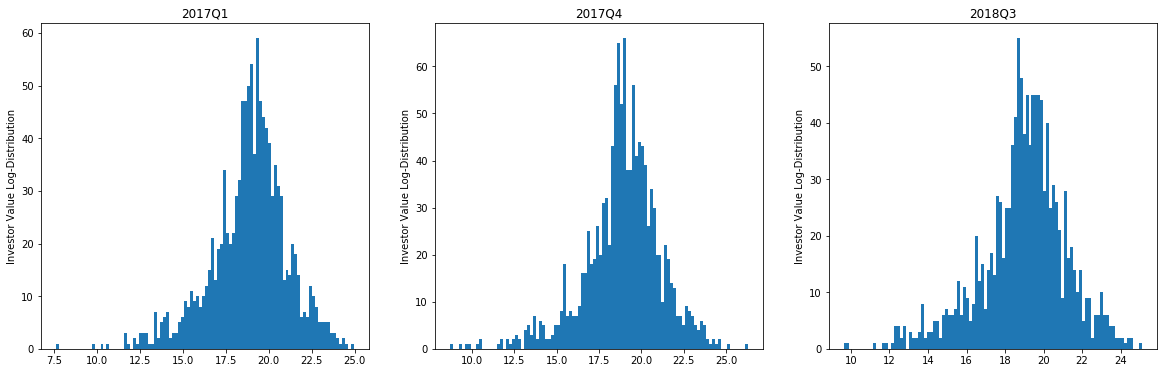

In [14] used 3.5469 MiB RAM in 0.75s, peaked 1.95 MiB above current, total RAM usage 1342.66 MiB


In [14]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [15]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['value_cat'] = pd.qcut(final_df.market_value_fund, 10, labels=list(range(10)))

In [15] used 72.0352 MiB RAM in 3.37s, peaked 555.81 MiB above current, total RAM usage 1414.69 MiB


In [16]:
final_df = final_df[~final_df.market_value_fund.isna()]
final_df = final_df.sort_values(by=['ticker_id', 'cik', 'period'])

In [16] used -68.9375 MiB RAM in 3.59s, peaked 661.12 MiB above current, total RAM usage 1345.75 MiB


Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [17]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_sum'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter - 1

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
final_df['object'] = final_df.ticker_id.apply(str) + '_' + final_df.cik.apply(str)

# Создаю лаги для переменных размера фондов
for lag in range(1, num_lags + 1):

    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    if lag == 1:
        
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund'] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
    
    else:
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund_lag' + '_' + str(lag - 1)] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
        
# Создаю переменную, выражающую долю акции в потрфеле

final_df['ticker_share'] = final_df.market_value.div(final_df.market_value_fund, axis=0)

Wall time: 7.11 s
In [17] used 657.4102 MiB RAM in 7.22s, peaked 91.16 MiB above current, total RAM usage 2003.16 MiB


## Создание зависимой переменной

In [18]:
final_df['ym_stamp'] = pd.to_datetime(final_df.stamp).dt.to_period('M')

In [18] used 56.2109 MiB RAM in 0.71s, peaked 0.00 MiB above current, total RAM usage 2059.38 MiB


In [19]:
prices = final_df.groupby(['period', 'ticker_id', 'ym_stamp'])['close'].median().reset_index()
prices.rename(columns={'close': 'mode_close'}, inplace=True)

prices = prices.groupby(['period', 'ticker_id']).first().reset_index().drop('ym_stamp', axis=1)

final_df = final_df.merge(prices, on=['period', 'ticker_id'], suffixes=(False, False), how='left')

final_df['close'] = final_df.close.fillna(final_df.mode_close)

In [19] used -75.9648 MiB RAM in 4.44s, peaked 848.47 MiB above current, total RAM usage 1983.41 MiB


In [20]:
final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['close_lag_4'] = final_df.close.shift(periods=4). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=4) == 4))

final_df['price_change_quarter'] = final_df.close.div(final_df.close_lag_1, axis=0).sub(1)
final_df['price_change_year'] = final_df.close.div(final_df.close_lag_4, axis=0).sub(1)

In [20] used 102.9922 MiB RAM in 1.04s, peaked 0.00 MiB above current, total RAM usage 2086.40 MiB


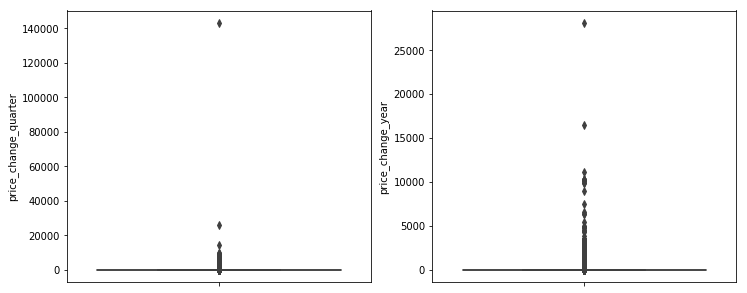

In [21] used -22.7891 MiB RAM in 1.47s, peaked 85.75 MiB above current, total RAM usage 2063.61 MiB


In [21]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["price_change_quarter"], ax=ax[0]);
sns.boxplot(y=(final_df["price_change_year"]), ax=ax[1]);
fig.show();

In [22]:
%%time

final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['shares_lag_1'] = final_df.shares.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['net_changes'] = final_df.close_lag_1 * (final_df.shares - final_df.shares_lag_1) \
                                                            / final_df.market_value_fund_lag_1

net_changes = final_df.groupby(by=['period', 'cik']).agg({'net_changes': lambda x: x.abs().sum(min_count=1)}).reset_index()

final_df = final_df.merge(net_changes, on=['period', 'cik'], how='left', suffixes=('', '_abs_sum'))

final_df['pct_in_change'] = final_df.net_changes.div(final_df.net_changes_abs_sum.add(1e-20), axis = 0)

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):

    final_df['pct_in_change' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    
    final_df['net_changes' + '_' + str(lag)] = final_df.net_changes.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

Wall time: 9.66 s
In [22] used -101.2891 MiB RAM in 9.77s, peaked 1034.80 MiB above current, total RAM usage 1962.32 MiB


But at what cost?

In [23]:
final_df[final_df.net_changes < -1].net_changes

883110    -1.0
1392823   -1.0
1578307   -1.0
Name: net_changes, dtype: float64

In [23] used -137.5469 MiB RAM in 3.97s, peaked 1443.12 MiB above current, total RAM usage 1824.78 MiB


In [24]:
final_df[(final_df.close - final_df.mode_close).abs() >= 7][['cik', 'period', 'ticker_id', 'shares', 'market_value',
                                                                  'close', 'mode_close']].head(15)

,cik,period,ticker_id,shares,market_value,close,mode_close
2277,1134008,2017Q2,835,47.0,1000.0,21.276596,11.650943
2634,1546408,2017Q2,835,13.0,1000.0,76.923077,11.650943
2635,1546408,2017Q3,835,13.0,1000.0,76.923077,11.897189
2636,1546408,2017Q4,835,13.0,1000.0,76.923077,12.192569
2637,1546408,2018Q1,835,13.0,1000.0,76.923077,12.280702
2638,1546408,2018Q2,835,13.0,1000.0,76.923077,13.845006
2639,1546408,2018Q3,835,13.0,1000.0,76.923077,11.300097
3678,1344551,2017Q4,902,37.0,1000.0,27.027027,37.738470
3729,1368465,2016Q4,902,40.0,2000.0,50.000000,40.838832
3730,1368465,2017Q1,902,30.0,1000.0,33.333333,43.601688


In [24] used 90.0859 MiB RAM in 0.35s, peaked 0.00 MiB above current, total RAM usage 1914.86 MiB


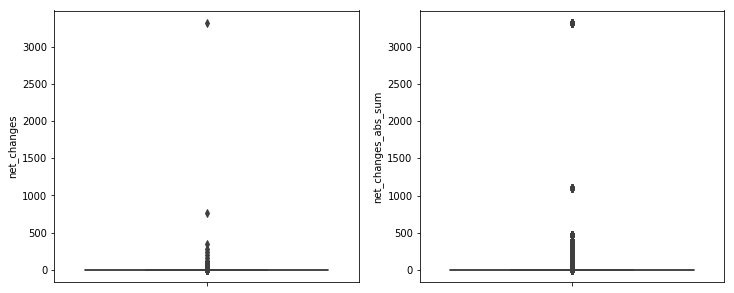

In [25] used 113.2930 MiB RAM in 4.87s, peaked 1.01 MiB above current, total RAM usage 2028.16 MiB


In [25]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

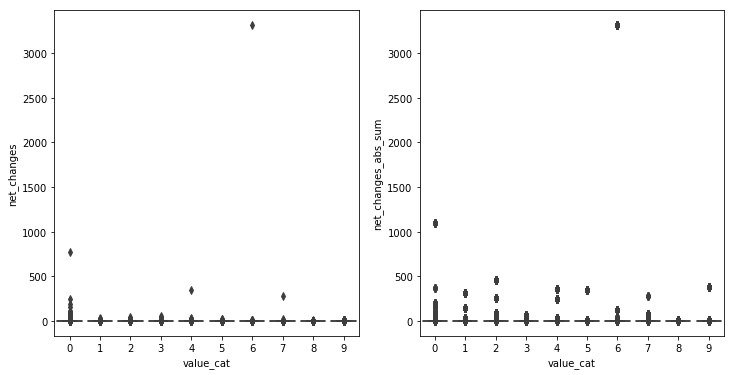

In [26] used 105.2852 MiB RAM in 5.32s, peaked 32.91 MiB above current, total RAM usage 2133.44 MiB


In [26]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

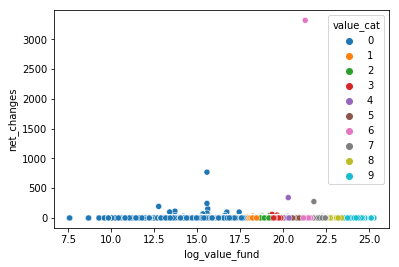

In [27] used -472.4297 MiB RAM in 137.93s, peaked 1230.70 MiB above current, total RAM usage 1661.01 MiB


In [27]:
sns.scatterplot(x='log_value_fund', y='net_changes', hue='value_cat', data=final_df);

Проблема просто net_changes в том, что в нем могут быть аутлаеры и изменения сравниваются не с собой, а с имеющимися и накопленными активами.

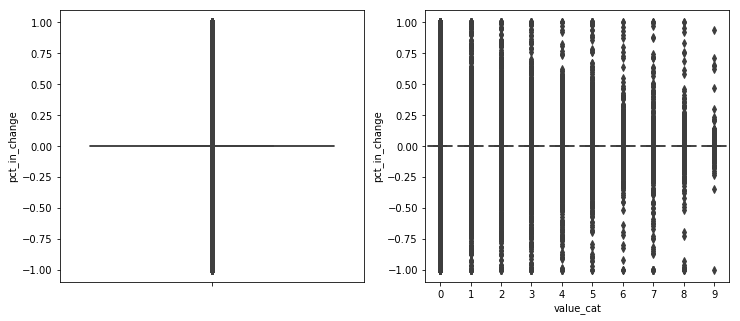

In [28] used 224.0742 MiB RAM in 10.35s, peaked 11.39 MiB above current, total RAM usage 1885.09 MiB


In [28]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

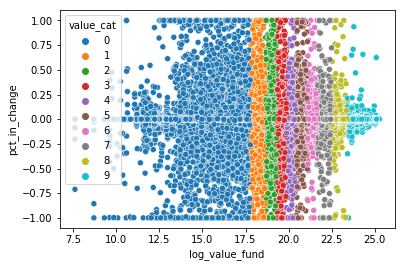

In [29] used -1647.8672 MiB RAM in 223.77s, peaked 2148.60 MiB above current, total RAM usage 237.22 MiB


In [29]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', hue='value_cat', data=final_df);

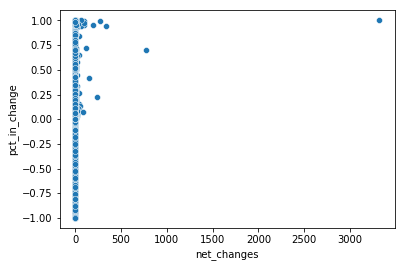

In [30] used 121.8594 MiB RAM in 39.73s, peaked 148.42 MiB above current, total RAM usage 359.08 MiB


In [30]:
sns.scatterplot(x='net_changes', y='pct_in_change', data=final_df);

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [34]:
for lag in range(1, num_lags + 1):

    final_df['ticker_share_lag' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

In [34] used 125.7500 MiB RAM in 1.83s, peaked 31.53 MiB above current, total RAM usage 1943.65 MiB


In [35]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
338,2016Q1,1156185,NaN
7058,2017Q3,1055282,1.122012
4803,2017Q1,1105871,1.644717
12155,2018Q3,1406026,1.734974
10013,2018Q1,1562668,1.407978


In [35] used 92.3086 MiB RAM in 25.91s, peaked 2380.34 MiB above current, total RAM usage 2035.96 MiB


In [36]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
5808,2017Q2,937567,1.676861
5173,2017Q1,1471474,NaN
11692,2018Q3,862469,NaN
12498,2018Q3,1593191,1.783633
12109,2018Q3,1367401,1.652675


In [36] used -3.7617 MiB RAM in 19.13s, peaked 2741.40 MiB above current, total RAM usage 2032.20 MiB


In [37]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
9293,2018Q1,900169,1.290350
6868,2017Q3,740913,2.000000
6138,2017Q2,1330325,1.992029
3461,2016Q4,903949,NaN
3357,2016Q4,45319,NaN


In [37] used 4.0000 MiB RAM in 17.79s, peaked 2755.97 MiB above current, total RAM usage 2036.20 MiB


Теперь HHI.

In [38]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,2230,0.017140
1,2016Q1,8565,0.648686
2,2016Q1,9015,0.004477
3,2016Q1,9631,0.082798
4,2016Q1,14661,0.048942


In [38] used 7.0938 MiB RAM in 15.40s, peaked 2926.27 MiB above current, total RAM usage 2043.29 MiB


Теперь посмотрю на их распределение.

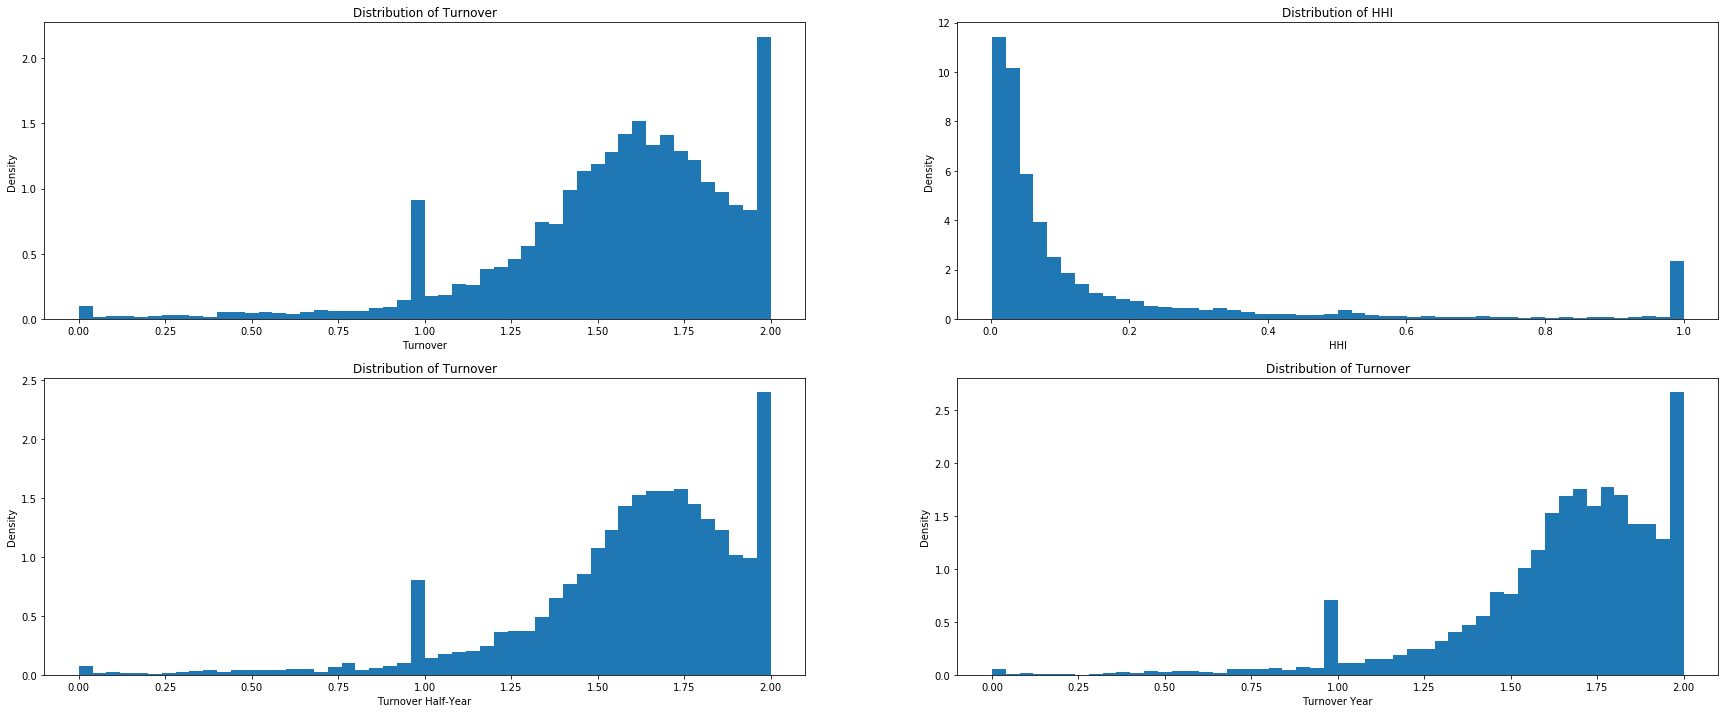

In [39] used 18.8750 MiB RAM in 1.25s, peaked 7.00 MiB above current, total RAM usage 2062.17 MiB


In [39]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

axs[0, 0].hist(turnover.turnover, density=True, bins=50);
axs[0, 0].set_title('Distribution of Turnover');
axs[0, 0].set(xlabel='Turnover', ylabel='Density');

axs[0, 1].hist(hhi.hhi, density=True, bins=50);
axs[0, 1].set_title('Distribution of HHI');
axs[0, 1].set(xlabel='HHI', ylabel='Density');

axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
axs[1, 0].set_title('Distribution of Turnover');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');

axs[1, 1].hist(turnover_year.turnover_year, density=True, bins=50);
axs[1, 1].set_title('Distribution of Turnover');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Density');

Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

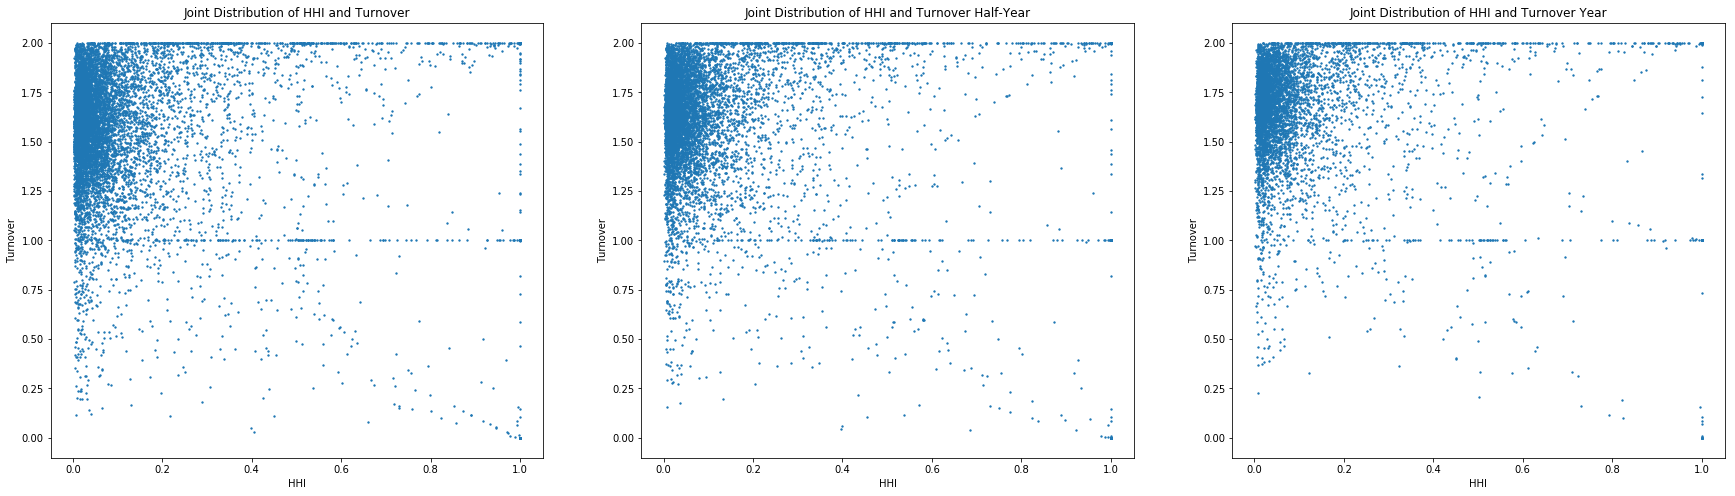

In [40] used 6.5820 MiB RAM in 0.81s, peaked 4.41 MiB above current, total RAM usage 2068.75 MiB


In [40]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Ещё в правых частях графиков можно наблюдать некую параболу. Она словно принимает минимальное значение при $Turnover=1$, равное $HHI=0.5$. Кроме того, при $Turnover \in \{0, 2\}$ она принимает значение $HHI=1$. Такой параболе соответствует уравнение:

$$HHI = \frac{{Turnover}^2}{2} - {Turnover} + 1$$ 

Я утверждаю, что такая парабола соответствует тем фондам, у которых в предыдущем периоде были активы только одного тикера, а в текущем добавился ещё один. Этот "один тикер" можно с погрешностью воспринимать как несколько тикеров, среди которых купленные активы одного из них значительно превышают остальные.

Итак, введем обозначения.

Пусть $x_{1,t_{0}} \gt 0$ - доля единственного тикера тикера в предыдущем периоде, $x_{1,t_{1}}=1$ - его же доля в текущем периоде, а $x_{2,t_{1}} \gt 0$ - доля купленного в текущем периоде нового тикера.
Тогда:
$$HHI = x_{1,t_{1}}^2 + x_{2,t_{1}}^2,$$
$$Turnover = |x_{1,t_{1}} - x_{1,t_{0}}| + |x_{2,t_{1}}| = 1 - x_{1,t_{1}} + x_{2,t_{1}}.$$
Кроме того, заметим, что
$$x_{1,t_{1}} + x_{2,t_{1}} = 1.$$

Теперь рассмотрим правую часть равенства (уравнение параболы). Раскроем его, подставив формулу Turnover.

$$ \frac{{(1 - x_{1,t_{1}} + x_{2,t_{1}})}^2}{2} - (1 - x_{1,t_{1}} + x_{2,t_{1}}) + 1 =
\frac{{(1  +  2 \cdot (x_{2,t_{1}} - x_{1,t_{1}}) + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} - 1 + x_{1,t_{1}} - x_{2,t_{1}} + 1 =
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} + (x_{2,t_{1}} - x_{1,t_{1}}) - (x_{2,t_{1}} - x_{1,t_{1}}) = 
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} = \frac{1}{2} + \frac{{(x_{2,t_{1}} - x_{1,t_{1}})^2}}{2} 
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2 - 2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2} $$

Теперь подставим преобразованную часть в исходное равенство, подставив формулу HHI.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 = \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}$$

Теперь домножим обе части равенства на два, приведем подобные слагаемые и перенесем все переменные в одну часть. Тогда получится следующее.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 + 2 \cdot x_{2,t_{1}} \cdot x_{1,t_{1}} = 1 $$

Заметим, что слева у нас полный квадрат, поэтому

$$ (x_{2,t_{1}} + x_{1,t_{1}})^2 = 1. $$

Но мы тогда возвращаемся к начальному условию, которое говорит, что $x_{1,t_{1}} + x_{2,t_{1}} = 1$. Это значит, что данная зависимость верна для любого фонда, которые перешел от инвестирования в один тикер к инвестированию в два тикера. $\blacksquare$

Из этого следует, что эта парабола совершенно естественная, в отличие от фондов, которые торгуют двумя тикерами, и никакого контроля осуществлять не следует.

In [41]:
final_df = final_df[final_df.net_changes.lt(np.nanquantile(final_df.net_changes, .9995)) & 
                   final_df.price_change_quarter.lt(np.nanquantile(final_df.price_change_quarter, .995)) & 
                   final_df.price_change_year.lt(np.nanquantile(final_df.price_change_year, .99))]

In [41] used 755.5430 MiB RAM in 1.04s, peaked 0.00 MiB above current, total RAM usage 2824.29 MiB


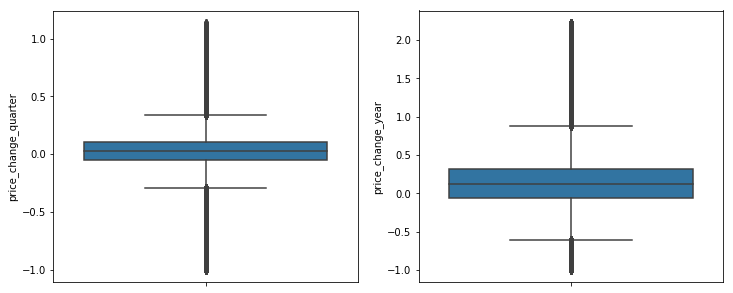

In [42] used 18.9844 MiB RAM in 1.07s, peaked 1.18 MiB above current, total RAM usage 2843.28 MiB


In [42]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["price_change_quarter"], ax=ax[0]);
sns.boxplot(y=(final_df["price_change_year"]), ax=ax[1]);
fig.show();

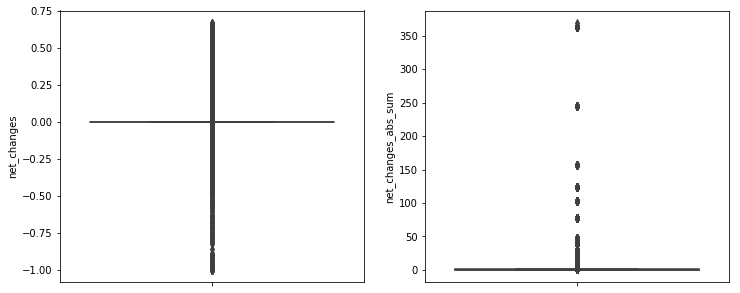

In [43] used 65.2773 MiB RAM in 3.29s, peaked 34.75 MiB above current, total RAM usage 2908.55 MiB


In [43]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

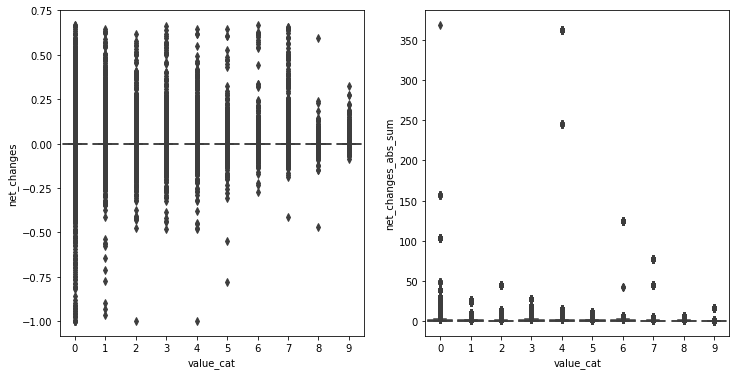

In [44] used 56.8594 MiB RAM in 4.03s, peaked 16.68 MiB above current, total RAM usage 2965.41 MiB


In [44]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

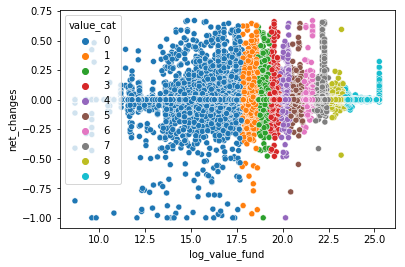

In [45] used 196.4141 MiB RAM in 132.68s, peaked 276.29 MiB above current, total RAM usage 3161.83 MiB


In [45]:
sns.scatterplot(x='log_value_fund', y='net_changes', hue='value_cat', data=final_df);

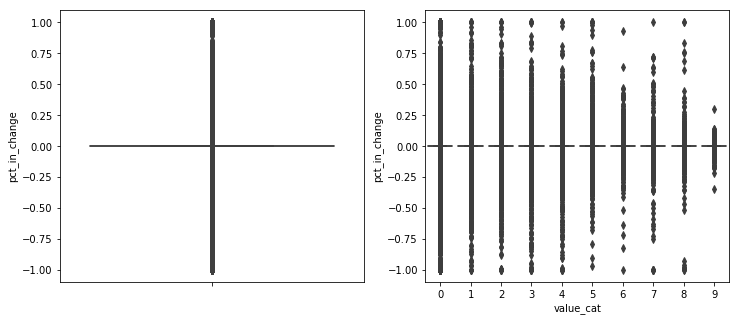

In [46] used 105.8945 MiB RAM in 5.36s, peaked 4.81 MiB above current, total RAM usage 3267.72 MiB


In [46]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

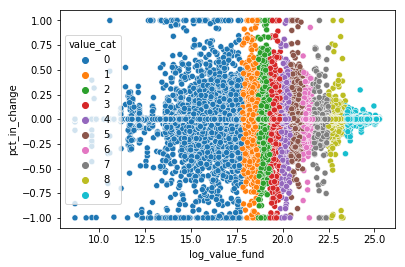

In [47] used -193.2070 MiB RAM in 160.00s, peaked 500.52 MiB above current, total RAM usage 3074.52 MiB


In [47]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', hue='value_cat', data=final_df);

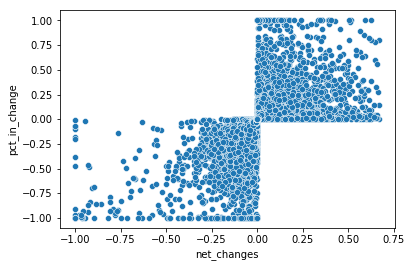

In [48] used 29.6406 MiB RAM in 21.76s, peaked 105.84 MiB above current, total RAM usage 3104.16 MiB


In [48]:
sns.scatterplot(x='net_changes', y='pct_in_change', data=final_df);

In [49]:
corr = final_df[['shares', 'ticker_share', 'shares_lag_1', 'net_changes', 'pct_in_change',
       'pct_in_change_1', 'net_changes_1', 'pct_in_change_2', 'net_changes_2',
       'pct_in_change_3', 'net_changes_3', 'pct_in_change_4', 'net_changes_4',
       'mode_close', 'net_changes_abs_sum', 'ticker_share_lag_1',
       'ticker_share_lag_2', 'ticker_share_lag_4']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,shares,ticker_share,shares_lag_1,net_changes,pct_in_change,pct_in_change_1,net_changes_1,pct_in_change_2,net_changes_2,pct_in_change_3,net_changes_3,pct_in_change_4,net_changes_4,mode_close,net_changes_abs_sum,ticker_share_lag_1,ticker_share_lag_2,ticker_share_lag_4
shares,1.00,0.90,0.75,0.21,0.20,0.11,0.12,0.09,0.09,0.08,0.08,0.08,0.08,0.04,-0.24,0.11,0.09,0.08
ticker_share,0.90,1.00,0.66,0.21,0.20,0.11,0.11,0.08,0.08,0.07,0.07,0.07,0.07,0.20,-0.24,0.11,0.08,0.07
shares_lag_1,0.75,0.66,1.00,-0.24,-0.23,0.21,0.21,0.11,0.11,0.10,0.10,0.09,0.09,0.04,-0.25,0.21,0.11,0.09
net_changes,0.21,0.21,-0.24,1.00,1.00,0.00,-0.01,0.04,0.03,0.03,0.03,0.03,0.03,-0.01,0.03,0.00,0.04,0.03
pct_in_change,0.20,0.20,-0.23,1.00,1.00,0.01,0.00,0.04,0.04,0.04,0.03,0.04,0.03,-0.01,0.03,0.01,0.04,0.04
pct_in_change_1,0.11,0.11,0.21,0.00,0.01,1.00,1.00,0.01,0.00,0.04,0.04,0.04,0.03,-0.01,0.02,1.00,0.01,0.04
net_changes_1,0.12,0.11,0.21,-0.01,0.00,1.00,1.00,0.00,-0.01,0.04,0.03,0.03,0.03,-0.01,0.02,1.00,0.00,0.03
pct_in_change_2,0.09,0.08,0.11,0.04,0.04,0.01,0.00,1.00,1.00,0.00,-0.00,0.04,0.04,-0.01,0.02,0.01,1.00,0.04
net_changes_2,0.09,0.08,0.11,0.03,0.04,0.00,-0.01,1.00,1.00,-0.01,-0.02,0.03,0.03,-0.01,0.02,0.00,1.00,0.03
pct_in_change_3,0.08,0.07,0.10,0.03,0.04,0.04,0.04,0.00,-0.01,1.00,1.00,0.01,-0.00,-0.01,0.01,0.04,0.00,0.01


In [49] used -2172.8750 MiB RAM in 84.88s, peaked 2441.84 MiB above current, total RAM usage 931.28 MiB


In [50]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
3777,2017Q4,1603142,1.961884
1209,2017Q2,1086131,1.481285
2176,2017Q3,1082482,1.649717
1231,2017Q2,1105876,1.768074
5990,2018Q3,9015,1.582757


In [50] used 374.7031 MiB RAM in 18.01s, peaked 1327.27 MiB above current, total RAM usage 1305.98 MiB


In [51]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
1679,2017Q2,1536630,1.082923
6535,2018Q3,1436866,1.319993
6182,2018Q3,1040188,0.859900
3970,2018Q1,741073,1.721787
3043,2017Q4,939791,0.721470


In [51] used 7.8320 MiB RAM in 9.39s, peaked 1579.98 MiB above current, total RAM usage 1313.82 MiB


In [52]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
6482,2018Q3,1391166,1.443411
4303,2018Q1,1278678,1.421675
915,2017Q1,1642044,NaN
1217,2017Q2,1092838,1.488687
4323,2018Q1,1308001,1.451123


In [52] used 2.0859 MiB RAM in 9.01s, peaked 1579.83 MiB above current, total RAM usage 1315.90 MiB


In [53]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2017Q1,2230,0.016569
1,2017Q1,9015,0.004864
2,2017Q1,9631,0.036278
3,2017Q1,14661,0.043096
4,2017Q1,35442,0.113723


In [53] used 0.7227 MiB RAM in 8.67s, peaked 1579.73 MiB above current, total RAM usage 1316.62 MiB


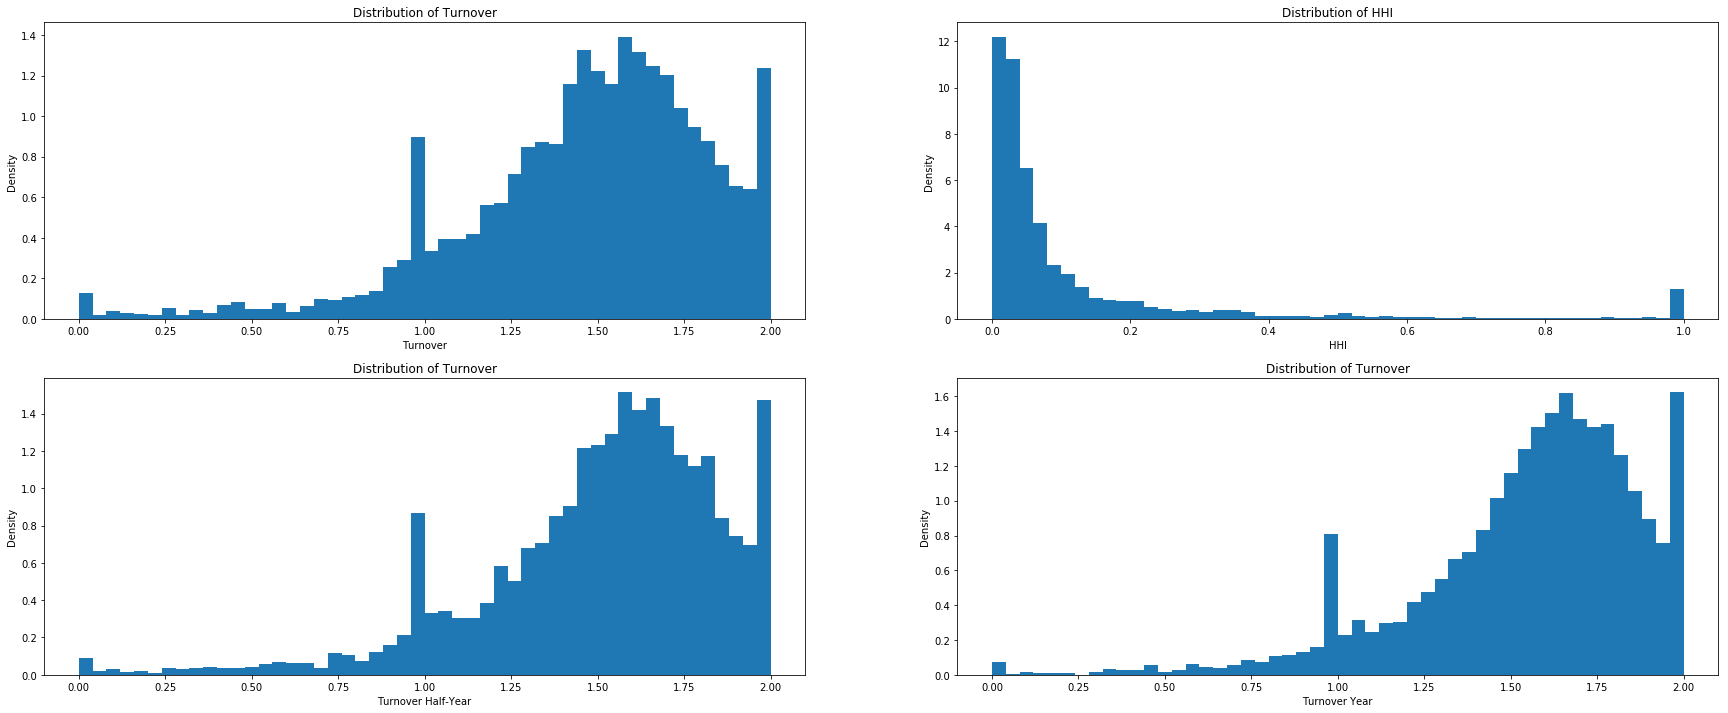

In [54] used 18.0117 MiB RAM in 1.54s, peaked 6.95 MiB above current, total RAM usage 1334.64 MiB


In [54]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

axs[0, 0].hist(turnover.turnover, density=True, bins=50);
axs[0, 0].set_title('Distribution of Turnover');
axs[0, 0].set(xlabel='Turnover', ylabel='Density');

axs[0, 1].hist(hhi.hhi, density=True, bins=50);
axs[0, 1].set_title('Distribution of HHI');
axs[0, 1].set(xlabel='HHI', ylabel='Density');

axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
axs[1, 0].set_title('Distribution of Turnover');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');

axs[1, 1].hist(turnover_year.turnover_year, density=True, bins=50);
axs[1, 1].set_title('Distribution of Turnover');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Density');

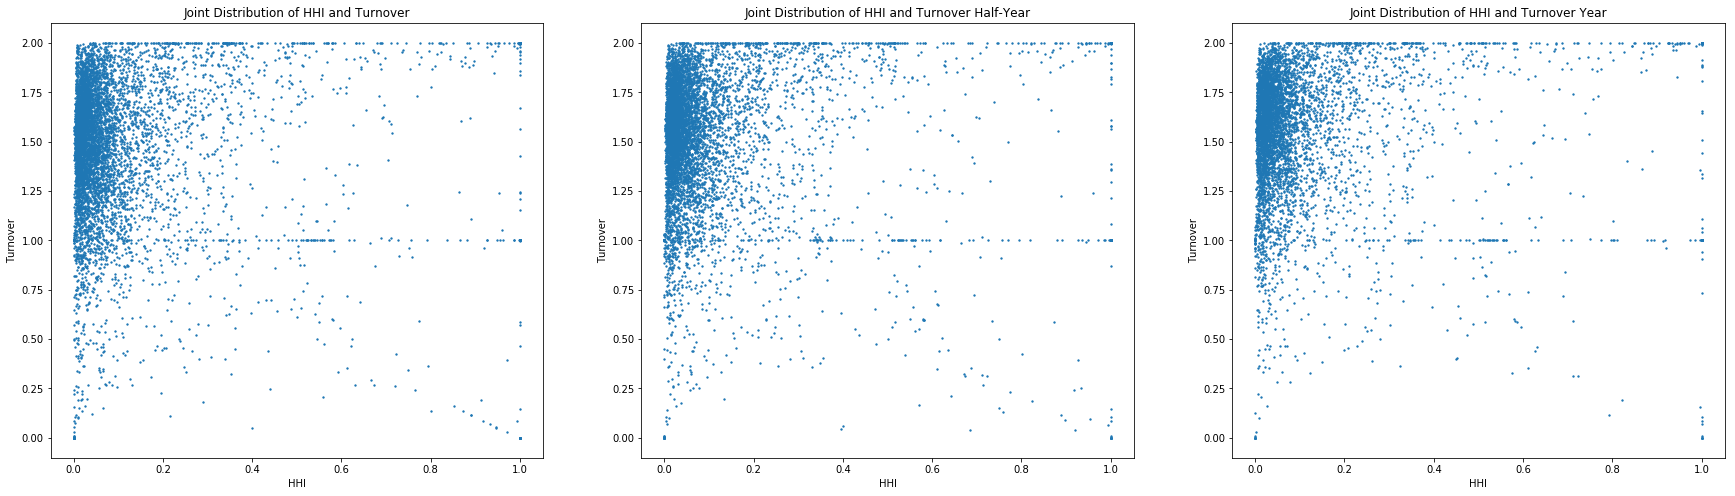

In [55] used 7.2734 MiB RAM in 0.98s, peaked 3.96 MiB above current, total RAM usage 1341.91 MiB


In [55]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

Добавляю переменные на основе наблюдений.

In [56]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_halfyear, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_year, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

In [56] used 66.2734 MiB RAM in 9.15s, peaked 1292.17 MiB above current, total RAM usage 1408.18 MiB


In [57]:
final_df['turnover_lag_1'] = final_df.turnover.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['turnover_halfyear_lag_1'] = final_df.turnover_halfyear.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['turnover_year_lag_1'] = final_df.turnover_year.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['hhi_lag_1'] = final_df.hhi.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

In [57] used 59.3633 MiB RAM in 1.32s, peaked 14.73 MiB above current, total RAM usage 1467.55 MiB


In [58]:
# Разграничиваю фонды по метрикам через индикаторы
final_df['hhi_cat'] = pd.cut(final_df.hhi, np.insert((1 / np.arange(10, 0, -1)) ** 1.5, 0, -1), labels=np.arange(10))
final_df['tvr_cat'] = pd.cut(final_df.turnover, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1), labels=np.arange(10))
final_df['tvr_half_cat'] = pd.cut(final_df.turnover_halfyear, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))
final_df['tvr_year_cat'] = pd.cut(final_df.turnover_year, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))

In [58] used 7.6055 MiB RAM in 0.56s, peaked 25.29 MiB above current, total RAM usage 1475.15 MiB


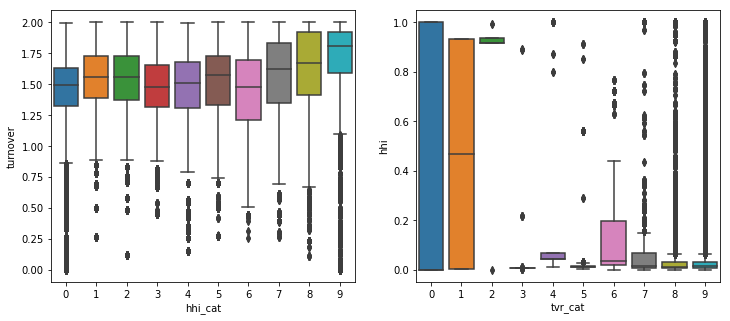

In [59] used 29.4258 MiB RAM in 2.18s, peaked 70.66 MiB above current, total RAM usage 1504.58 MiB


In [59]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df, ax=ax[1]);

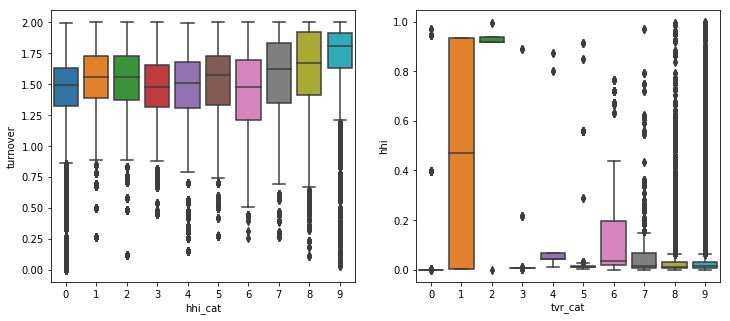

In [60] used 980.5078 MiB RAM in 6.29s, peaked 415.84 MiB above current, total RAM usage 2485.09 MiB


In [60]:
final_df_slice = final_df[final_df.hhi.ne(1)]

fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df_slice, ax=ax[1]);

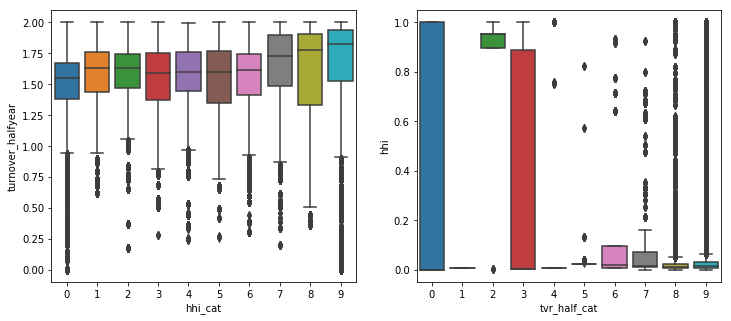

In [61] used 21.8633 MiB RAM in 2.72s, peaked 41.50 MiB above current, total RAM usage 2506.95 MiB


In [61]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_halfyear', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_half_cat', y='hhi', data=final_df, ax=ax[1]);

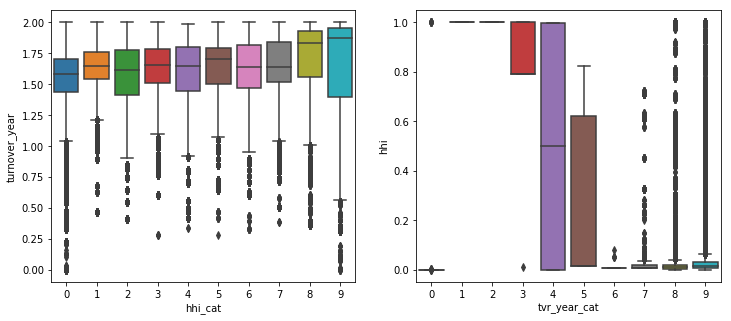

In [62] used 18.4180 MiB RAM in 2.72s, peaked 40.31 MiB above current, total RAM usage 2525.37 MiB


In [62]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_year', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_year_cat', y='hhi', data=final_df, ax=ax[1]);

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

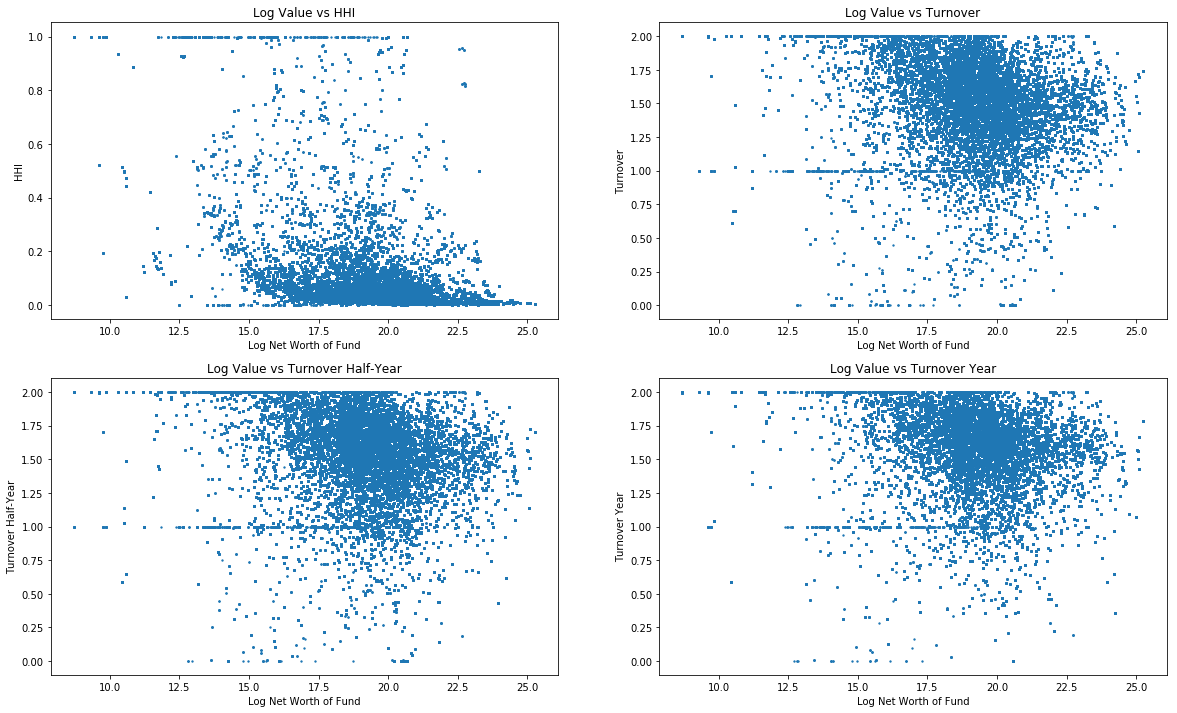

In [63] used 108.2539 MiB RAM in 64.44s, peaked 29.52 MiB above current, total RAM usage 2633.62 MiB


In [63]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.log_value_fund,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Log Value vs HHI');
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[0, 1].scatter(final_df.log_value_fund,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Log Value vs Turnover');
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

axs[1, 0].scatter(final_df.log_value_fund,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Log Value vs Turnover Half-Year');
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.log_value_fund,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Log Value vs Turnover Year');
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Year');

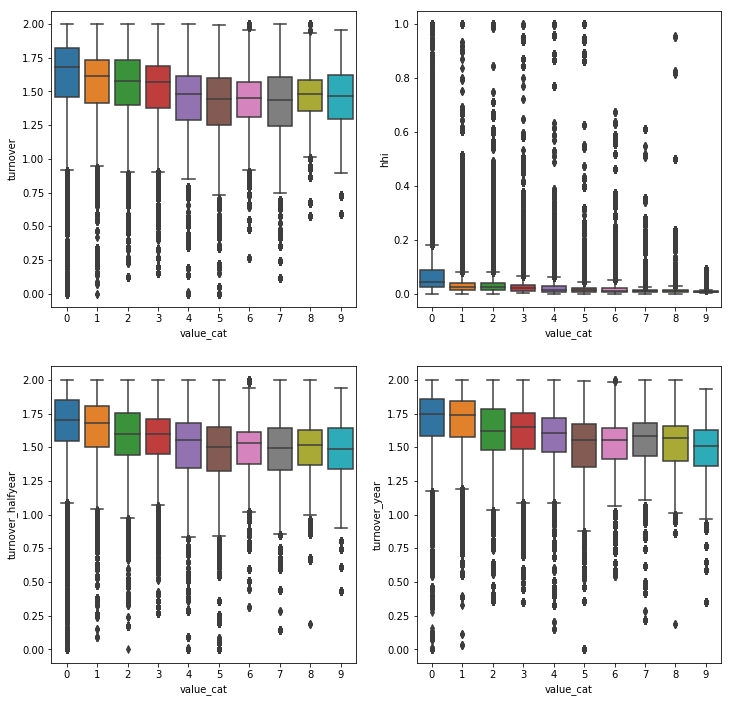

In [64] used -57.9648 MiB RAM in 3.68s, peaked 103.14 MiB above current, total RAM usage 2575.66 MiB


In [64]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='value_cat', y='turnover', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='value_cat', y='hhi', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='value_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='value_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

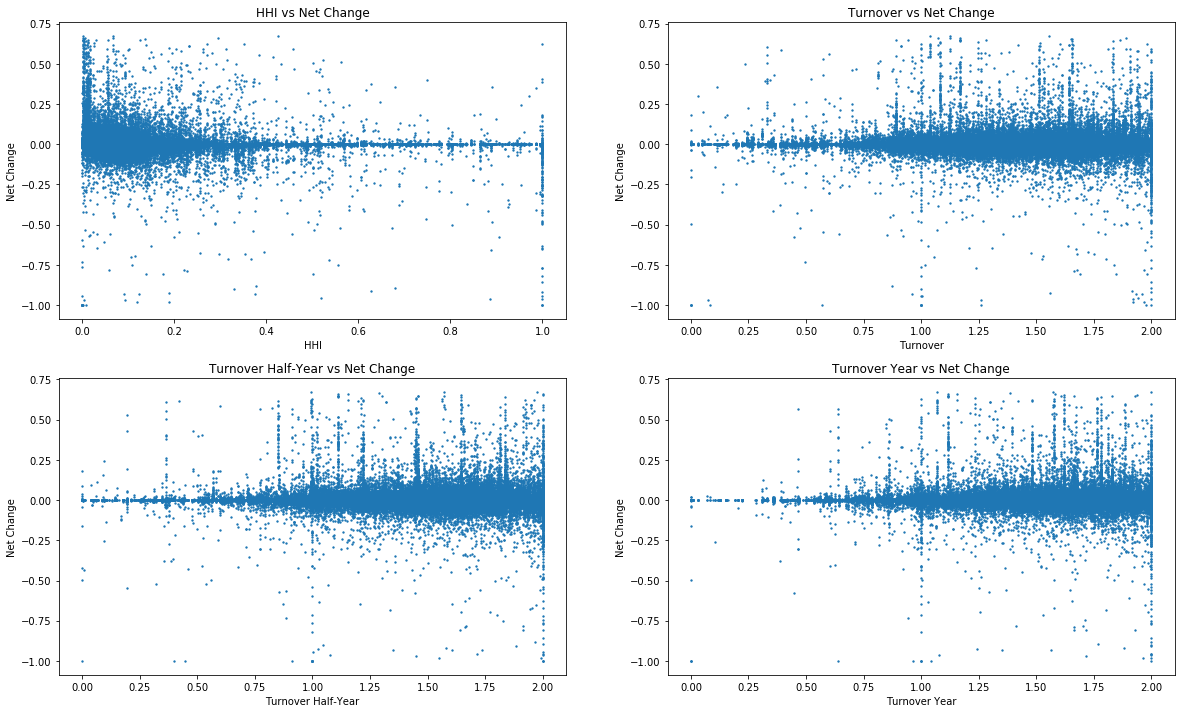

In [65] used 116.7188 MiB RAM in 68.11s, peaked 21.12 MiB above current, total RAM usage 2692.38 MiB


In [65]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');

axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');

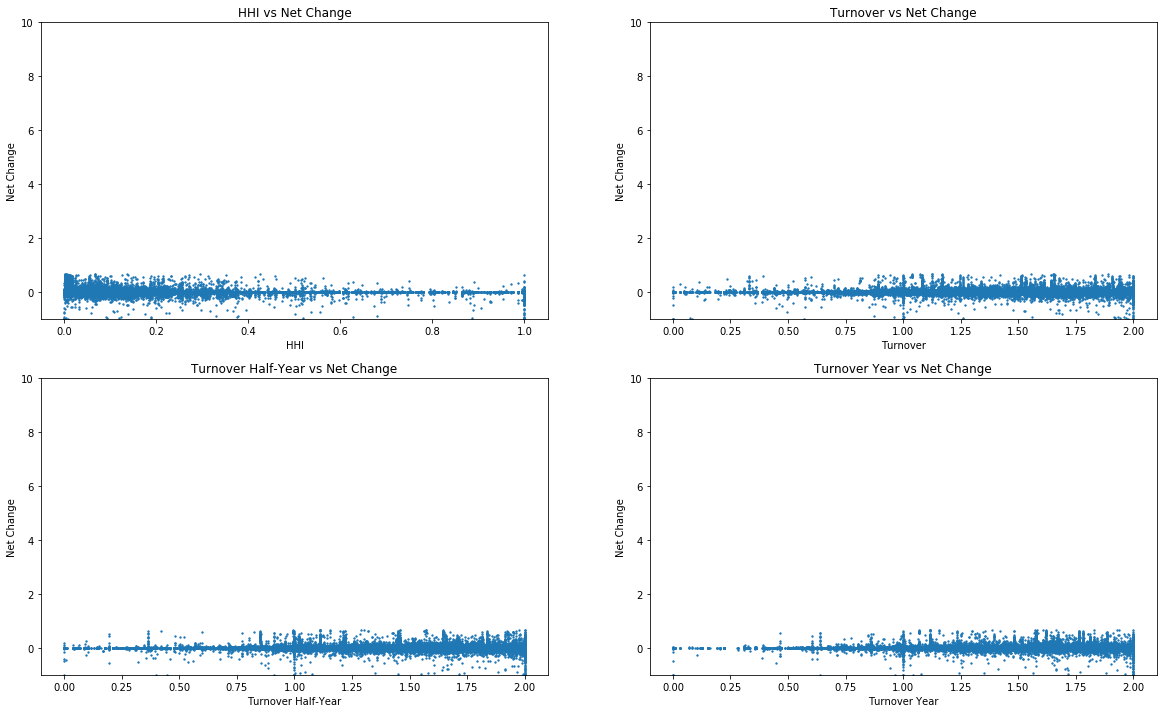

In [66] used 83.6680 MiB RAM in 68.87s, peaked 54.16 MiB above current, total RAM usage 2776.04 MiB


In [66]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');
axs[0, 0].set_ylim(-1, 10);

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');
axs[0, 1].set_ylim(-1, 10);

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');
axs[1, 0].set_ylim(-1, 10);

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');
axs[1, 1].set_ylim(-1, 10);

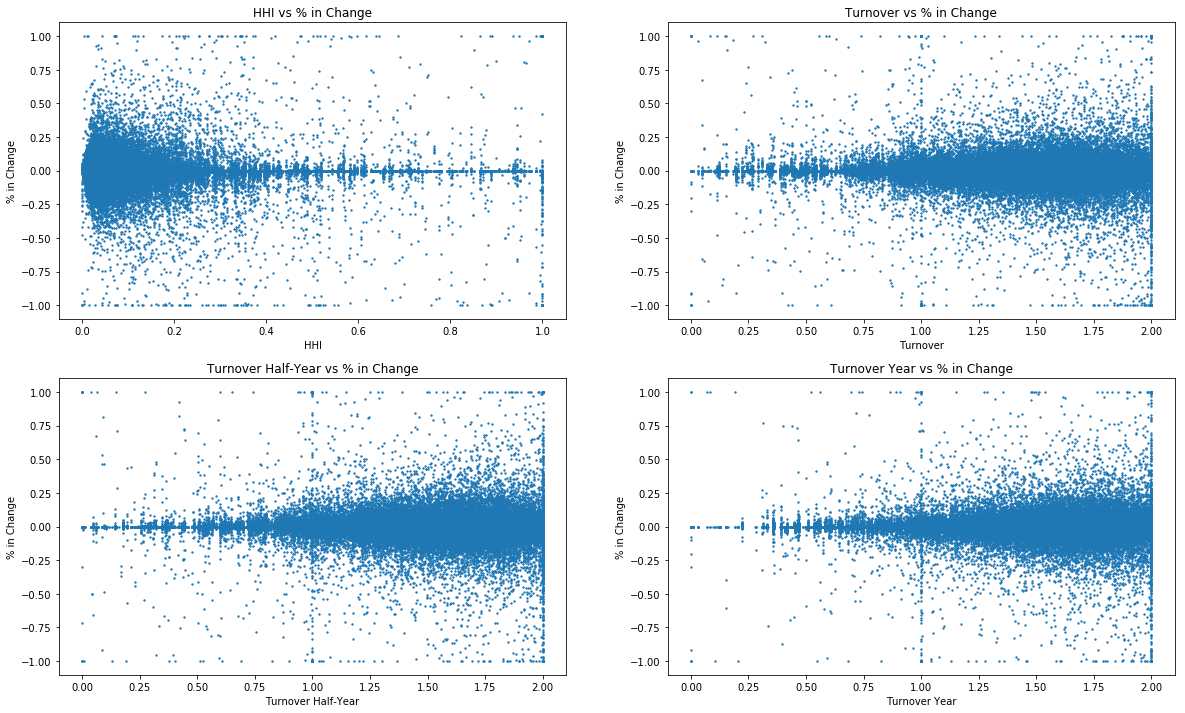

In [67] used 116.4062 MiB RAM in 72.14s, peaked 21.37 MiB above current, total RAM usage 2892.45 MiB


In [67]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.pct_in_change, s=1.8);
axs[0, 0].set_title('HHI vs % in Change');
axs[0, 0].set(xlabel='HHI', ylabel='% in Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.pct_in_change, s=1.8);
axs[0, 1].set_title('Turnover vs % in Change');
axs[0, 1].set(xlabel='Turnover', ylabel='% in Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.pct_in_change, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs % in Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='% in Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.pct_in_change, s=1.8);
axs[1, 1].set_title('Turnover Year vs % in Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='% in Change');

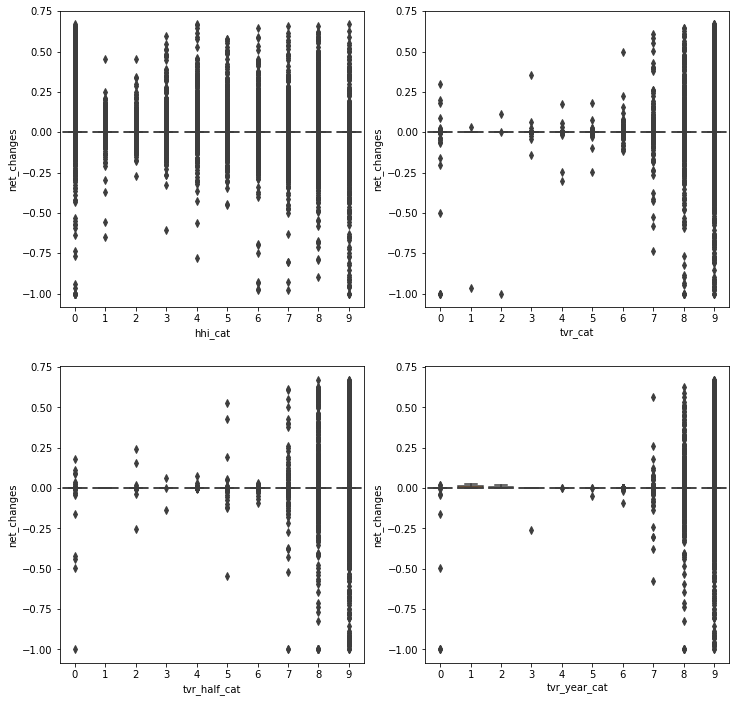

In [68] used 225.2695 MiB RAM in 13.11s, peaked 14.49 MiB above current, total RAM usage 3117.72 MiB


In [68]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='net_changes', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='net_changes', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='net_changes', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='net_changes', data=final_df, ax=ax[1, 1]);

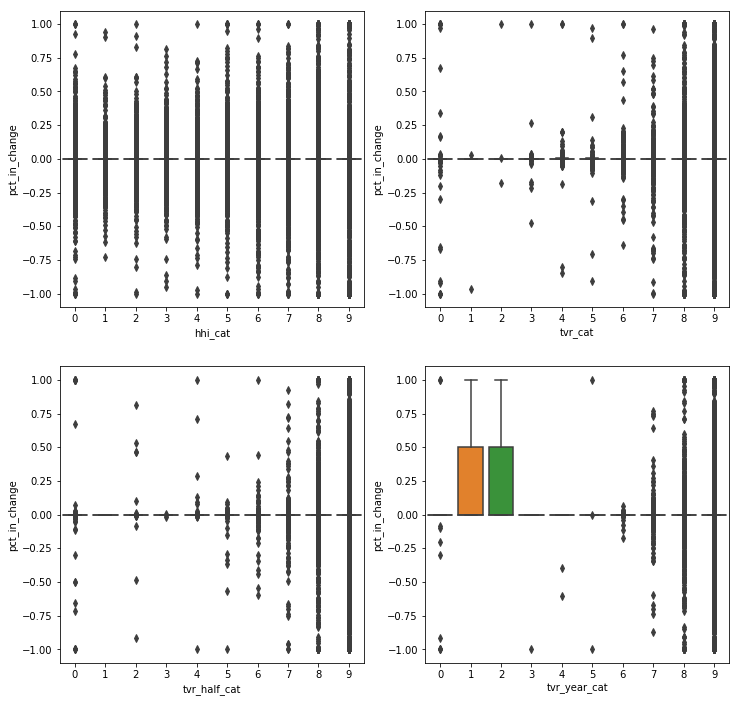

In [69] used -161.8828 MiB RAM in 13.15s, peaked 161.89 MiB above current, total RAM usage 2955.84 MiB


In [69]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='pct_in_change', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pct_in_change', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pct_in_change', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pct_in_change', data=final_df, ax=ax[1, 1]);

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [70]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).apply(lambda x: x[x.shares != 0].ticker_id.nunique()).reset_index()
pos_count.rename(columns={0: 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2017Q1,2230,77
1,2017Q1,9015,810
2,2017Q1,9631,655
3,2017Q1,14661,676
4,2017Q1,35442,135


In [70] used -1528.1562 MiB RAM in 31.32s, peaked 1613.11 MiB above current, total RAM usage 1427.68 MiB


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [71]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))

In [71] used 21.5469 MiB RAM in 6.27s, peaked 1579.03 MiB above current, total RAM usage 1449.23 MiB


Теперь посмотрим на распределение количества позиций в фонде.

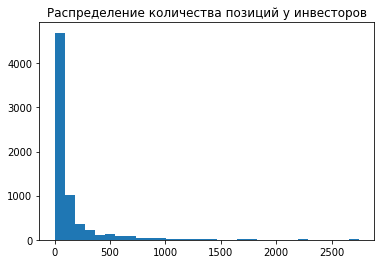

In [72] used 9.4648 MiB RAM in 0.55s, peaked 0.00 MiB above current, total RAM usage 1458.69 MiB


In [72]:
pl.hist(pos_count.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [73]:
final_df['pos_count_cat'] = pd.cut(final_df.pos_count, [-1, 30, 200, 500, 1000, 2000, 1e32],
                                  labels=['<=30', '30-200', '200-500', '500-1000', '1000-2000', '>2000'])

In [73] used 2.2617 MiB RAM in 0.20s, peaked 29.39 MiB above current, total RAM usage 1460.95 MiB


Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

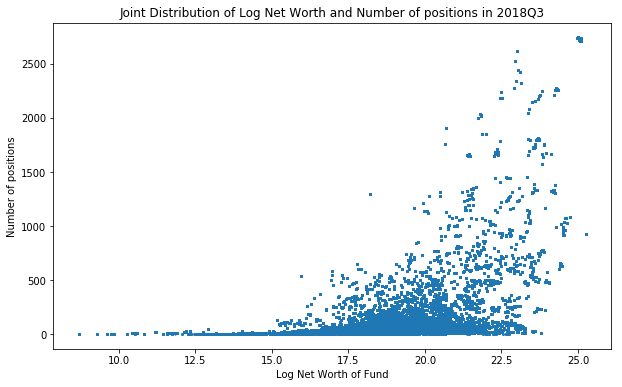

In [74] used 31.6875 MiB RAM in 17.29s, peaked 1.18 MiB above current, total RAM usage 1492.64 MiB


In [74]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df.log_value_fund,
            final_df.pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

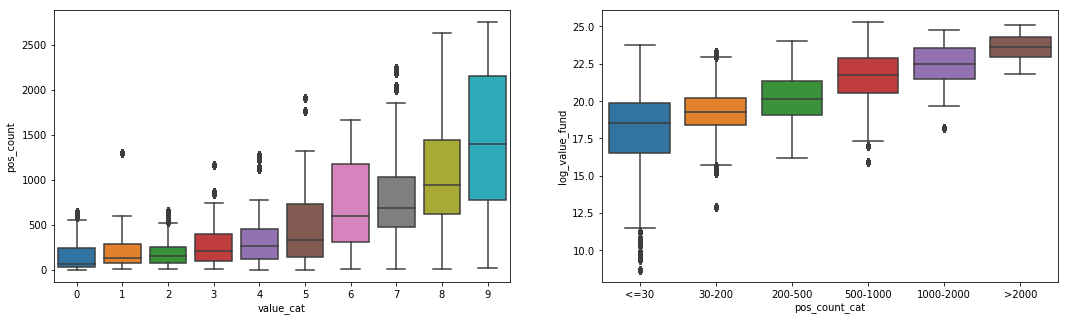

In [75] used 14.4688 MiB RAM in 1.47s, peaked 28.96 MiB above current, total RAM usage 1507.11 MiB


In [75]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='value_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='log_value_fund', data=final_df, ax=ax[1]);

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

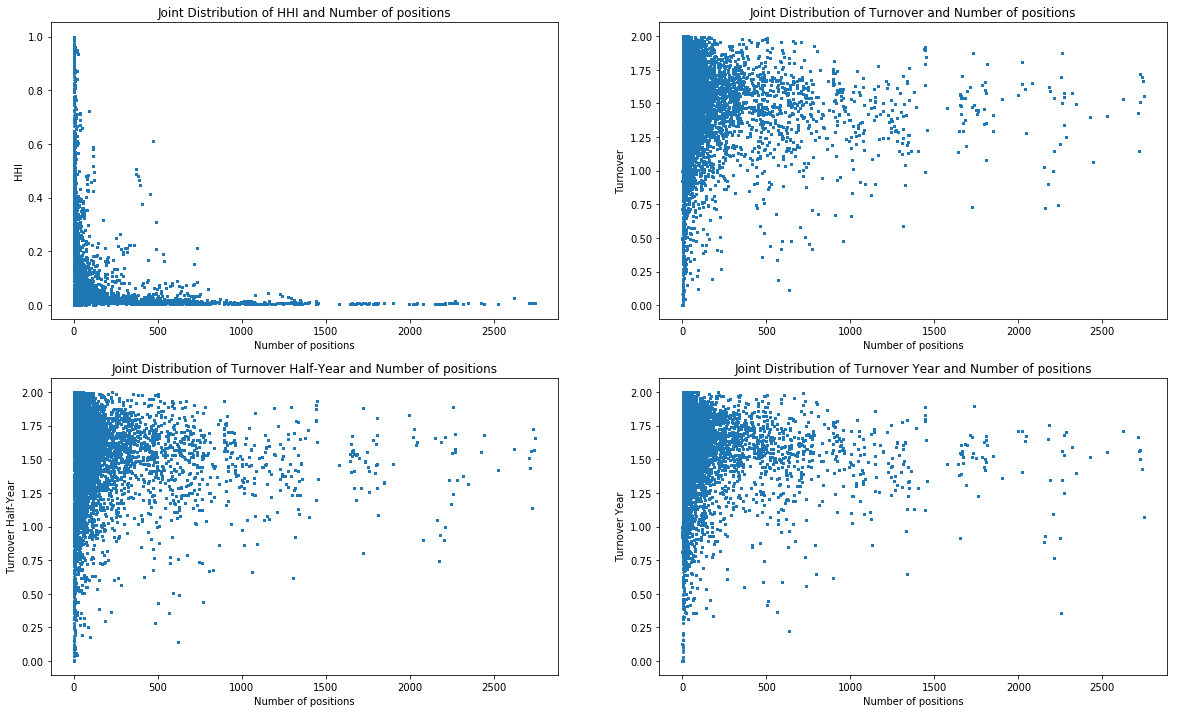

In [76] used 130.5977 MiB RAM in 72.27s, peaked 8.08 MiB above current, total RAM usage 1637.71 MiB


In [76]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].scatter(final_df.pos_count,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Joint Distribution of HHI and Number of positions');
axs[0, 0].set(xlabel='Number of positions', ylabel='HHI');

axs[0, 1].scatter(final_df.pos_count,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Joint Distribution of Turnover and Number of positions');
axs[0, 1].set(xlabel='Number of positions', ylabel='Turnover');

axs[1, 0].scatter(final_df.pos_count,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Joint Distribution of Turnover Half-Year and Number of positions');
axs[1, 0].set(xlabel='Number of positions', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.pos_count,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Joint Distribution of Turnover Year and Number of positions');
axs[1, 1].set(xlabel='Number of positions', ylabel='Turnover Year');

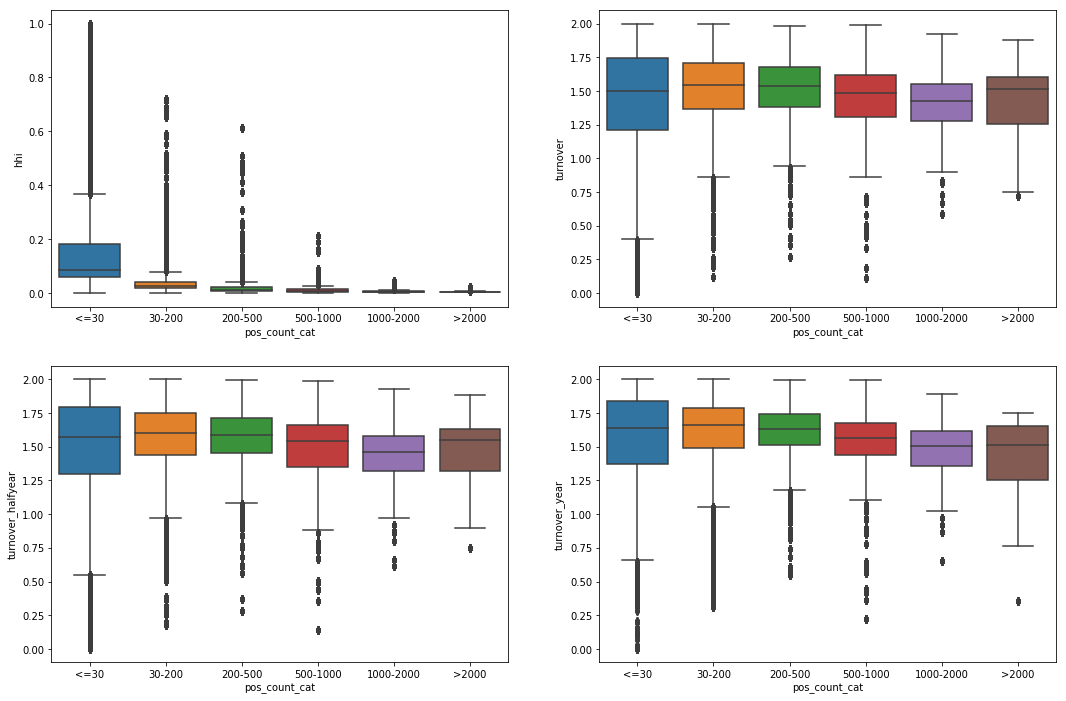

In [77] used 49.5117 MiB RAM in 3.75s, peaked 19.45 MiB above current, total RAM usage 1687.22 MiB


In [77]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='pos_count_cat', y='hhi', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='pos_count_cat', y='turnover', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='pos_count_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='pos_count_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

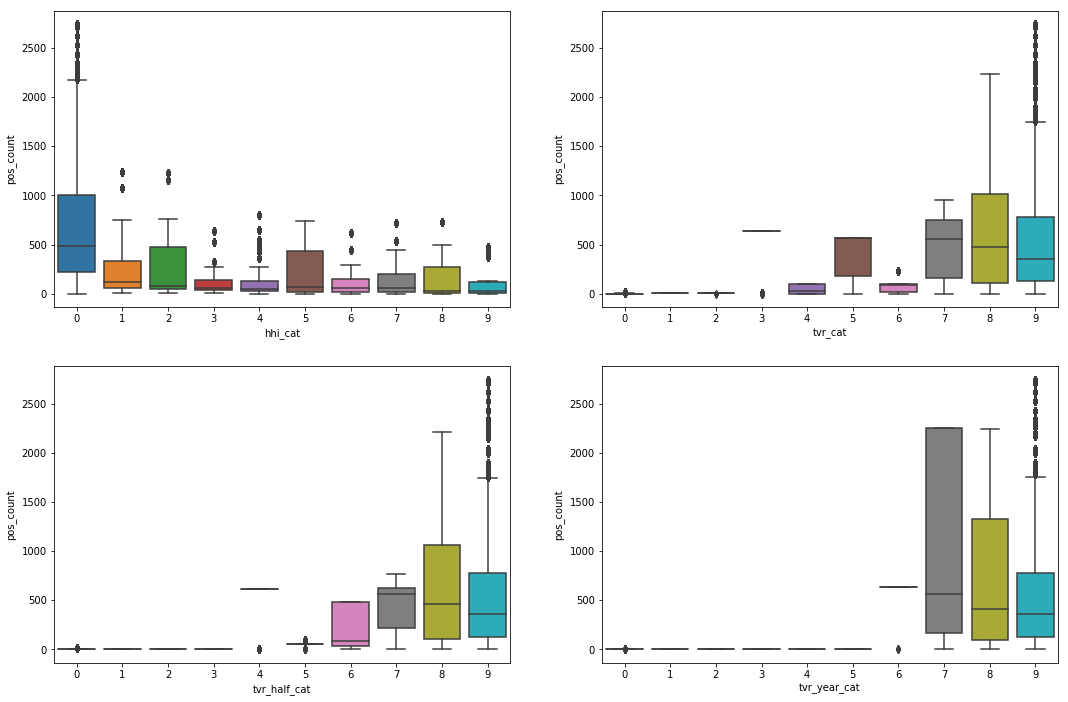

In [78] used 19.6797 MiB RAM in 3.67s, peaked 45.91 MiB above current, total RAM usage 1706.90 MiB


In [78]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='hhi_cat', y='pos_count', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pos_count', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pos_count', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pos_count', data=final_df, ax=ax[1, 1]);

Связь с зависимой переменной.

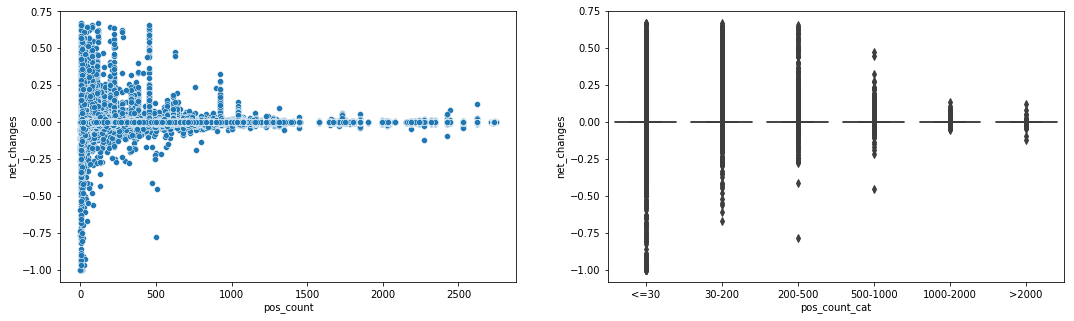

In [79] used 85.7656 MiB RAM in 28.16s, peaked 48.93 MiB above current, total RAM usage 1792.66 MiB


In [79]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='net_changes', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='net_changes', data=final_df, ax=ax[1]);

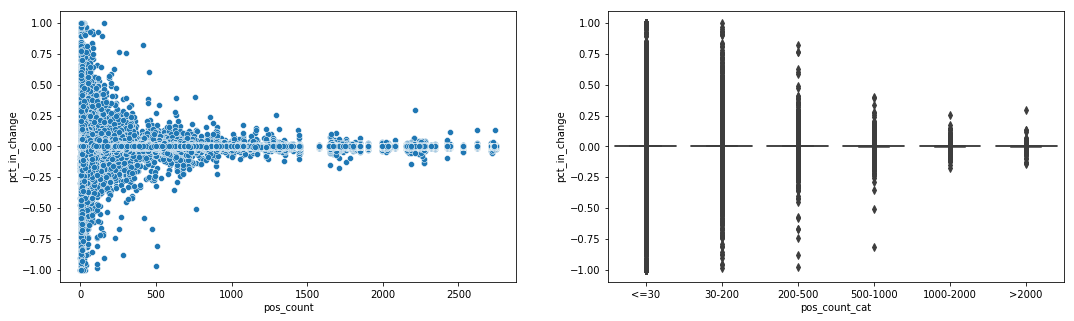

In [80] used -76.5586 MiB RAM in 28.62s, peaked 212.16 MiB above current, total RAM usage 1716.11 MiB


In [80]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='pct_in_change', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='pct_in_change', data=final_df, ax=ax[1]);

Корреляция переменных, связанных с фондами.

In [81]:
corr = final_df[['log_value_fund', 'value_cat', 'net_changes_abs_sum', 'turnover', 'turnover_halfyear', 'turnover_year',
'hhi', 'hhi_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat',
'pos_count', 'pos_count_cat']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_value_fund,net_changes_abs_sum,turnover,turnover_halfyear,turnover_year,hhi,pos_count
log_value_fund,1.00,-0.12,-0.24,-0.27,-0.30,-0.52,0.69
net_changes_abs_sum,-0.12,1.00,-0.04,0.03,0.12,-0.07,-0.05
turnover,-0.24,-0.04,1.00,0.38,0.33,0.16,-0.14
turnover_halfyear,-0.27,0.03,0.38,1.00,0.39,0.20,-0.18
turnover_year,-0.30,0.12,0.33,0.39,1.00,0.23,-0.23
hhi,-0.52,-0.07,0.16,0.20,0.23,1.00,-0.72
pos_count,0.69,-0.05,-0.14,-0.18,-0.23,-0.72,1.00


In [81] used 4.3008 MiB RAM in 9.33s, peaked 1357.21 MiB above current, total RAM usage 1720.41 MiB


Добавление средних изменений зависимых переменных.

In [82]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_pct_in_change = final_df.groupby(['ticker_id', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change.rename(columns={'pct_in_change': 'mean_pct_in_change'}, inplace=True)

mean_pct_in_change_by_cik = final_df.groupby(['cik', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_cik.rename(columns={'pct_in_change': 'mean_pct_in_change_by_cik'}, inplace=True)

mean_pct_in_change_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_value.rename(columns={'pct_in_change': 'mean_pct_in_change_by_value'}, inplace=True)

mean_pct_in_change_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_pos_count.rename(columns={'pct_in_change': 'mean_pct_in_change_by_pos_count'}, inplace=True)



mean_net_changes = final_df.groupby(['ticker_id', 'period'])['net_changes'].mean().reset_index()
mean_net_changes.rename(columns={'net_changes': 'mean_net_changes'}, inplace=True)

mean_net_changes_by_cik = final_df.groupby(['cik', 'period'])['net_changes'].mean().reset_index()
mean_net_changes_by_cik.rename(columns={'net_changes': 'mean_net_changes_by_cik'}, inplace=True)

mean_net_changes_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_value.rename(columns={'net_changes': 'mean_net_changes_by_value'}, inplace=True)

mean_net_changes_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_pos_count.rename(columns={'net_changes': 'mean_net_changes_by_pos_count'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_pct_in_change, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))


final_df = final_df.merge(mean_net_changes, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat'])\
                                                            .count().reset_index()
tickers_count_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)
tickers_count_by_pos_count.rename(columns={'shares': 'tickers_count_by_pos_count'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))

final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'value_cat', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'value_cat'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_pos_count[['ticker_id', 'period', 'pos_count_cat', 'tickers_count_by_pos_count']], 
                                                                        on=['ticker_id', 'period', 'pos_count_cat'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_pct_in_change'] -= final_df.pct_in_change.div(final_df.tickers_count, axis=0).values
final_df['mean_pct_in_change_by_cik'] -= final_df.pct_in_change.div(final_df.pos_count, axis=0).values
final_df['mean_pct_in_change_by_value'] -= final_df.pct_in_change.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_pct_in_change_by_pos_count'] -= final_df.pct_in_change.div(final_df.tickers_count_by_pos_count, axis=0).values

final_df['mean_net_changes'] -= final_df.net_changes.div(final_df.tickers_count, axis=0).values
final_df['mean_net_changes_by_cik'] -= final_df.net_changes.div(final_df.pos_count, axis=0).values
final_df['mean_net_changes_by_value'] -= final_df.net_changes.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_net_changes_by_pos_count'] -= final_df.net_changes.div(final_df.tickers_count_by_pos_count, axis=0).values

Wall time: 1min 9s
In [82] used 637.9883 MiB RAM in 69.14s, peaked 1809.47 MiB above current, total RAM usage 2358.39 MiB


In [83]:
from janitor import groupby_agg

ticker_value = final_df.groupby(['period', 'ticker_id'])['market_value'].sum().reset_index()
ticker_value.rename(columns={'market_value': 'market_value_ticker'}, inplace=True)
ticker_value = ticker_value.groupby_agg(
    by='period',
    agg='sum',
    agg_column_name='market_value_ticker',
    new_column_name='tickers_total_value'
)

ticker_value['ticker_market_share'] = ticker_value.market_value_ticker.div(ticker_value.tickers_total_value.add(1e-20), axis=0)

final_df = final_df.merge(ticker_value, on=['period', 'ticker_id'], how='left', suffixes=(None, None))
final_df['bench_dev'] =  (final_df.ticker_share - final_df.ticker_market_share).abs() / 2
final_df['active_share'] = final_df.groupby(['period', 'cik']).bench_dev.transform('sum')
final_df['log_market_value_ticker'] = np.log(final_df.market_value_ticker.add(1e-20))

ticker_value.head(10)

,period,ticker_id,market_value_ticker,tickers_total_value,ticker_market_share
0,2017Q1,779,3.257200e+07,1.210490e+12,2.690811e-05
1,2017Q1,780,5.095200e+07,1.210490e+12,4.209204e-05
2,2017Q1,784,5.645000e+07,1.210490e+12,4.663400e-05
3,2017Q1,829,8.669000e+07,1.210490e+12,7.161562e-05
4,2017Q1,835,3.954700e+07,1.210490e+12,3.267024e-05
5,2017Q1,838,7.700000e+05,1.210490e+12,6.361060e-07
6,2017Q1,902,8.874100e+07,1.210490e+12,7.330998e-05
7,2017Q1,932,0.000000e+00,1.210490e+12,0.000000e+00
8,2017Q1,976,1.606000e+06,1.210490e+12,1.326735e-06
9,2017Q1,978,1.280454e+09,1.210490e+12,1.057798e-03


In [83] used 102.9961 MiB RAM in 4.05s, peaked 1044.96 MiB above current, total RAM usage 2461.39 MiB


<h2> Макро-индикаторы </h2>

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [84]:
import pandas_datareader as wb

In [84] used 0.7578 MiB RAM in 0.52s, peaked 0.00 MiB above current, total RAM usage 2462.15 MiB


In [85]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [85] used 5.9609 MiB RAM in 4.79s, peaked 4.92 MiB above current, total RAM usage 2468.11 MiB


In [86]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [86] used 0.3125 MiB RAM in 0.54s, peaked 0.00 MiB above current, total RAM usage 2468.42 MiB


In [87]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [87] used 0.0352 MiB RAM in 0.40s, peaked 0.00 MiB above current, total RAM usage 2468.46 MiB


In [88]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 10.8 s
In [88] used -607.9727 MiB RAM in 10.93s, peaked 2312.62 MiB above current, total RAM usage 1860.48 MiB


## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [215]:
%%time

final_df['enter'] = final_df.shares_lag_1.eq(0) & final_df.shares.ne(0)
final_df['exit'] = final_df.shares_lag_1.ne(0) & final_df.shares.eq(0)

features = final_df.drop(['access_id', 'conformed_submission_type', 'stamp', 'nid', 'ym_stamp', 'mode_close',
               'cik', 'period', 'ticker_id', 'shares', 'market_value', 'close',
               '_object', 'market_value_fund', 'quarter_sum', 'object', 'market_value_fund_lag_1',
               'diff_value_fund_lag_1', 'market_value_fund_lag_2', 'diff_value_fund_lag_2',
               'market_value_fund_lag_3', 'diff_value_fund_lag_3', 'market_value_fund_lag_4', 'diff_value_fund_lag_4',
               'close_lag_1', 'close_lag_4', 'shares_lag_1', 'net_changes_abs_sum',
               'ticker_share_lag_1', 'ticker_share_lag_2', 'ticker_share_lag_3', 'ticker_share_lag_4'], axis=1)

features = final_df.copy()
features = features.replace([np.inf, -np.inf], np.nan).dropna(subset=['net_changes', 'pct_in_change'])

Wall time: 2.42 s
In [215] used 772.8555 MiB RAM in 2.55s, peaked 1488.30 MiB above current, total RAM usage 2318.66 MiB


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>.

### Модель 1

In [92]:
import statsmodels.api as sm

In [92] used 46.8203 MiB RAM in 1.41s, peaked 0.00 MiB above current, total RAM usage 1048.26 MiB


In [216]:
data_common = features[~features.exit & ~features.enter].drop(['hhi_cat',  'value_cat', 'tvr_cat',
                                                        'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat'], axis=1).fillna(0)

In [216] used 628.1953 MiB RAM in 1.40s, peaked 658.93 MiB above current, total RAM usage 2946.86 MiB


In [217]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [217] used -216.0195 MiB RAM in 2.22s, peaked 1668.43 MiB above current, total RAM usage 2730.84 MiB


Делаю первую модель. Простой метод наименьших квадратов.

In [218]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4070.
Date:                Fri, 25 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:05:01   Log-Likelihood:             4.3707e+06
No. Observations:             1633720   AIC:                        -8.741e+06
Df Residuals:                 1633686   BIC:                        -8.741e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0053      0.000     13.556      0.000       0.005       0.006
log_value_fund                     -0.0001   9.38e-06    -11.186      0.000      -0.000   -8.65e-05
price_change_quarter               -0.0021    9.5e-05    -21.835      0.000      -0.002      -0.002
price_change_year                  -0.0003   4.15e-05     -6.581      0.000      -0.000      -0.000
diff_value_fund_rank_lag_1          0.0029   5.09e-05     57.461      0.000       0.003       0.003
diff_value_fund_rank_lag_2         -0.0001   5.46e-05     -2.668      0.008      -0.000   -3.87e-05
diff_value_fund_rank_lag_3       1.333e-05   5.41e-05      0.246      0.806   -9.28e-05       0.000
diff_value_fund_rank_lag_4      -2.196e-05   5.05e-05     -0.434      0.664      -0.000    7.71e-05
ticker_share                       -0.0752      0.007    -10.067      0.000      -0.090      -0.061
pct_in_change_1                     0.0637      0.001    113.859      0.000       0.063       0.065
pct_in_change_2                     0.0400      0.001     74.075      0.000       0.039       0.041
pct_in_change_3                     0.0077      0.001     14.560      0.000       0.007       0.009
pct_in_change_4                     0.0146      0.001     24.990      0.000       0.013       0.016
turnover                           -0.0009   5.61e-05    -15.149      0.000      -0.001      -0.001
turnover_halfyear                  -0.0003   5.93e-05     -5.627      0.000      -0.000      -0.000
turnover_year                   -8.385e-05   3.27e-05     -2.562      0.010      -0.000   -1.97e-05
hhi                                -0.0039      0.000    -19.315      0.000      -0.004      -0.004
hhi_eq_1                           -0.0012      0.000     -3.303      0.001      -0.002      -0.000
pos_count                       -7.229e-09   2.92e-08     -0.248      0.804   -6.44e-08       5e-08
mean_pct_in_change                  0.1014      0.005     22.087      0.000       0.092       0.110
mean_pct_in_change_by_cik          -0.6175      0.002   -329.055      0.000      -0.621      -0.614
mean_pct_in_change_by_value         0.0015      0.002      0.723      0.470      -0.003       0.006
mean_pct_in_change_by_pos_count     0.0388      0.002     18.032      0.000       0.035       0.043
tickers_count                    2.056e-07   3.23e-07      0.636      0.525   -4.28e-07    8.39e-07
tickers_count_by_value           2.157e-06   2.39e-06      0.903      0.366   -2.52e-06    6.84e-06
log_market_value_ticker          2.622e-06   5.97e-06      0.439      0.661   -9.08e-06    1.43e-05
ticker_market_share                -0.0409      0.011     -3.771      0.000      -0.062      -0.020
bench_dev                           0.0988      0.015      6.524      0.000       0

In [218] used -1782.6289 MiB RAM in 7.73s, peaked 2893.80 MiB above current, total RAM usage 948.21 MiB


In [219]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)
np.square(delta_1).sum(), np.square(y - y.mean()).sum()

(453.9031291474771, 491.21582170667097)

In [219] used 33.5625 MiB RAM in 0.30s, peaked 2.40 MiB above current, total RAM usage 981.77 MiB


<b>MemoryError, когда хочу использовать матрицу робастных стандартных ошибок.

Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

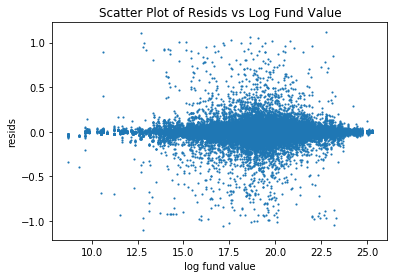

In [220] used 37.7539 MiB RAM in 10.90s, peaked 0.00 MiB above current, total RAM usage 1019.53 MiB


In [220]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

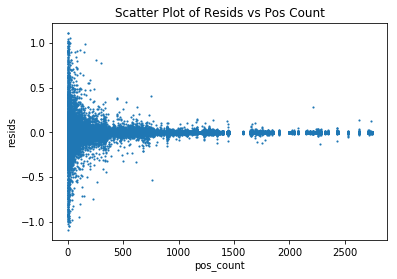

In [221] used 26.8203 MiB RAM in 10.84s, peaked 0.00 MiB above current, total RAM usage 1046.35 MiB


In [221]:
pl.scatter(X.pos_count, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Pos Count');
pl.xlabel('pos_count');
pl.ylabel('resids');

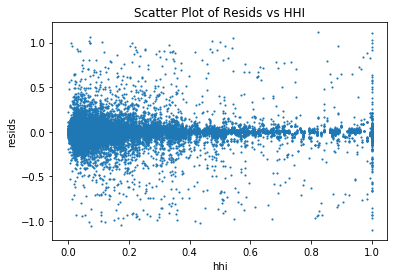

In [222] used 26.4648 MiB RAM in 14.10s, peaked 0.46 MiB above current, total RAM usage 1072.81 MiB


In [222]:
pl.scatter(X.hhi, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs HHI');
pl.xlabel('hhi');
pl.ylabel('resids');

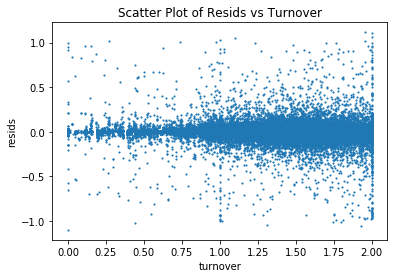

In [223] used 26.5977 MiB RAM in 16.75s, peaked 1.36 MiB above current, total RAM usage 1099.41 MiB


In [223]:
pl.scatter(X.turnover, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Turnover');
pl.xlabel('turnover');
pl.ylabel('resids');

Ну это странно.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

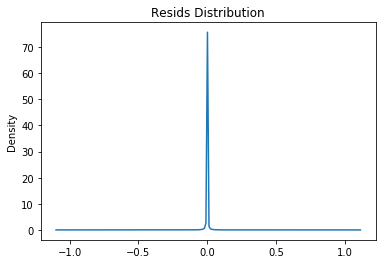

In [224] used 5.8008 MiB RAM in 26.42s, peaked 147.98 MiB above current, total RAM usage 1105.21 MiB


In [224]:
sns.kdeplot(delta_1).set_title("Resids Distribution");

Ну норм.

### Модель 2

In [225]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover_lag_1', 'turnover_halfyear_lag_1',
       'turnover_year_lag_1', 'hhi_lag_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [225] used 654.1211 MiB RAM in 1.81s, peaked 1258.64 MiB above current, total RAM usage 1759.33 MiB


In [226]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     4168.
Date:                Fri, 25 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:07:44   Log-Likelihood:             4.3703e+06
No. Observations:             1633720   AIC:                        -8.740e+06
Df Residuals:                 1633687   BIC:                        -8.740e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0040      0.000      8.976      0.000       0.003       0.005
log_value_fund                  -7.894e-05   9.37e-06     -8.425      0.000   -9.73e-05   -6.06e-05
price_change_quarter               -0.0021   9.51e-05    -21.648      0.000      -0.002      -0.002
price_change_year                  -0.0003   4.16e-05     -6.910      0.000      -0.000      -0.000
diff_value_fund_rank_lag_1          0.0031   5.06e-05     60.270      0.000       0.003       0.003
diff_value_fund_rank_lag_2          0.0002   4.91e-05      4.306      0.000       0.000       0.000
diff_value_fund_rank_lag_3       2.641e-05   5.31e-05      0.498      0.619   -7.76e-05       0.000
diff_value_fund_rank_lag_4      -3.273e-05   5.38e-05     -0.609      0.543      -0.000    7.27e-05
ticker_share                       -0.0715      0.007     -9.575      0.000      -0.086      -0.057
pct_in_change_1                     0.0644      0.001    115.288      0.000       0.063       0.065
pct_in_change_2                     0.0403      0.001     74.670      0.000       0.039       0.041
pct_in_change_3                     0.0079      0.001     14.854      0.000       0.007       0.009
pct_in_change_4                     0.0147      0.001     25.279      0.000       0.014       0.016
turnover_lag_1                     -0.0003   5.58e-05     -4.802      0.000      -0.000      -0.000
turnover_halfyear_lag_1          -8.32e-06   5.77e-05     -0.144      0.885      -0.000       0.000
turnover_year_lag_1                 0.0001   4.03e-05      3.128      0.002     4.7e-05       0.000
hhi_lag_1                          -0.0020      0.000    -10.402      0.000      -0.002      -0.002
pos_count                       -3.662e-08   2.91e-08     -1.259      0.208   -9.36e-08    2.04e-08
mean_pct_in_change                  0.1007      0.005     21.937      0.000       0.092       0.110
mean_pct_in_change_by_cik          -0.6142      0.002   -327.812      0.000      -0.618      -0.611
mean_pct_in_change_by_value         0.0016      0.002      0.755      0.450      -0.003       0.006
mean_pct_in_change_by_pos_count     0.0394      0.002     18.287      0.000       0.035       0.044
tickers_count                   -1.241e-08   3.23e-07     -0.038      0.969   -6.46e-07    6.21e-07
tickers_count_by_value           2.097e-06   2.39e-06      0.878      0.380   -2.58e-06    6.78e-06
log_market_value_ticker          2.976e-06   5.98e-06      0.498      0.619   -8.74e-06    1.47e-05
ticker_market_share                -0.0389      0.011     -3.588      0.000      -0.060      -0.018
bench_dev                           0.0877      0.015      5.799      0.000       0.058       0.117
active_share                        0.0009      0.000      7.942      0.000       0

In [226] used -637.6445 MiB RAM in 9.68s, peaked 1828.18 MiB above current, total RAM usage 1121.69 MiB


In [227]:
delta_2 = y - model_2.predict(X)
np.square(delta_2).sum(), np.square(y - y.mean()).sum()

(454.136585849906, 491.21582170667097)

In [227] used 16.1914 MiB RAM in 0.25s, peaked 16.13 MiB above current, total RAM usage 1137.88 MiB


(Тут старые объяснения)

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

### Модель 4

In [228]:
y = data_common['net_changes']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker', 'tickers_total_value',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [228] used 753.8594 MiB RAM in 4.07s, peaked 1214.53 MiB above current, total RAM usage 1891.74 MiB


In [230]:
model_3 = sm.OLS(y, X).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     739.1
Date:                Fri, 25 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:08:25   Log-Likelihood:             5.9887e+06
No. Observations:             1633720   AIC:                        -1.198e+07
Df Residuals:                 1633696   BIC:                        -1.198e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0012      0.000      6.485      0.000       0.001       0.002
log_value_fund                 -1.33e-05   3.48e-06     -3.822      0.000   -2.01e-05   -6.48e-06
price_change_quarter             -0.0009    3.5e-05    -26.494      0.000      -0.001      -0.001
price_change_year             -6.386e-05   1.53e-05     -4.161      0.000   -9.39e-05   -3.38e-05
diff_value_fund_rank_lag_1        0.0010   1.86e-05     53.102      0.000       0.001       0.001
diff_value_fund_rank_lag_2      -3.9e-05   1.99e-05     -1.964      0.050   -7.79e-05    -7.1e-08
diff_value_fund_rank_lag_3     1.233e-05   2.02e-05      0.611      0.541   -2.72e-05    5.19e-05
diff_value_fund_rank_lag_4    -9.905e-05   1.88e-05     -5.279      0.000      -0.000   -6.23e-05
ticker_share                      0.0054      0.000     28.423      0.000       0.005       0.006
net_changes_1                  2.832e-05   1.49e-05      1.897      0.058   -9.38e-07    5.76e-05
net_changes_2                  2.571e-05   1.98e-05      1.296      0.195   -1.32e-05    6.46e-05
net_changes_3                 -3.025e-05   6.83e-06     -4.430      0.000   -4.36e-05   -1.69e-05
net_changes_4                 -3.402e-05   7.23e-06     -4.707      0.000   -4.82e-05   -1.99e-05
turnover                         -0.0002   2.07e-05    -10.679      0.000      -0.000      -0.000
turnover_halfyear              -1.71e-05   2.22e-05     -0.771      0.440   -6.05e-05    2.63e-05
turnover_year                  8.436e-05   1.14e-05      7.389      0.000     6.2e-05       0.000
hhi                              -0.0011   7.49e-05    -15.340      0.000      -0.001      -0.001
hhi_eq_1                         -0.0017      0.000    -12.404      0.000      -0.002      -0.001
pos_count                     -7.157e-08   1.08e-08     -6.597      0.000   -9.28e-08   -5.03e-08
mean_net_changes                  0.0041      0.000     13.232      0.000       0.004       0.005
mean_net_changes_by_cik          -0.1564      0.001   -112.506      0.000      -0.159      -0.154
mean_net_changes_by_value         0.0073      0.001      5.062      0.000       0.004       0.010
mean_net_changes_by_pos_count     0.0217      0.001     14.902      0.000       0.019       0.025
tickers_count                  1.553e-07   1.13e-07      1.371      0.170   -6.67e-08    3.77e-07
tickers_count_by_value          2.84e-07   8.83e-07      0.322      0.748   -1.45e-06    2.01e-06
log_market_value_ticker        6.346e-06   2.21e-06      2.868      0.004    2.01e-06    1.07e-05
tickers_total_value           -8.771e-16   1.23e-16     -7.102      0.000   -1.12e-15   -6.35e-16
ticker_market_share               0.0007   5.61e-05     13.281      0.000       0.001       0.001
bench_dev                         0.0023     

In [230] used 462.2891 MiB RAM in 6.24s, peaked 1258.09 MiB above current, total RAM usage 2365.32 MiB


In [231]:
delta_3 = y - model_3.predict(X)
np.square(delta_3).sum(), np.square(y - y.mean()).sum()

(62.622563911439755, 63.27418637936679)

In [231] used 14.1406 MiB RAM in 0.28s, peaked 2.03 MiB above current, total RAM usage 2379.46 MiB


### Модель 5

In [232]:
y = data_common['net_changes']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'hhi_eq_1', 'turnover_lag_1', 'turnover_halfyear_lag_1',
       'turnover_year_lag_1', 'hhi_lag_1', 'pos_count',
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker', 'tickers_total_value',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [232] used 577.4102 MiB RAM in 2.95s, peaked 1127.79 MiB above current, total RAM usage 2956.87 MiB


In [233]:
model_4 = sm.OLS(y, X).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     722.6
Date:                Fri, 25 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:09:06   Log-Likelihood:             5.9885e+06
No. Observations:             1633720   AIC:                        -1.198e+07
Df Residuals:                 1633696   BIC:                        -1.198e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0003      0.000     -1.642      0.101      -0.001    5.59e-05
log_value_fund                -6.139e-06   3.47e-06     -1.768      0.077   -1.29e-05    6.68e-07
price_change_quarter             -0.0009   3.51e-05    -26.200      0.000      -0.001      -0.001
price_change_year             -7.105e-05   1.54e-05     -4.619      0.000      -0.000   -4.09e-05
diff_value_fund_rank_lag_1        0.0010   1.86e-05     55.002      0.000       0.001       0.001
diff_value_fund_rank_lag_2     5.991e-05   1.81e-05      3.316      0.001    2.45e-05    9.53e-05
diff_value_fund_rank_lag_3     1.661e-05   1.93e-05      0.861      0.389   -2.12e-05    5.44e-05
diff_value_fund_rank_lag_4       -0.0001   1.99e-05     -5.199      0.000      -0.000   -6.46e-05
ticker_share                      0.0052      0.000     27.799      0.000       0.005       0.006
net_changes_1                  5.298e-05   1.53e-05      3.469      0.001     2.3e-05    8.29e-05
net_changes_2                  2.414e-05   1.98e-05      1.217      0.224   -1.47e-05     6.3e-05
net_changes_3                 -3.069e-05   6.83e-06     -4.494      0.000   -4.41e-05   -1.73e-05
net_changes_4                 -3.534e-05   7.23e-06     -4.890      0.000   -4.95e-05   -2.12e-05
hhi_eq_1                         -0.0027      0.000    -22.837      0.000      -0.003      -0.003
turnover_lag_1                 1.357e-05   1.99e-05      0.683      0.494   -2.53e-05    5.25e-05
turnover_halfyear_lag_1        7.921e-05   2.03e-05      3.903      0.000    3.94e-05       0.000
turnover_year_lag_1            -9.08e-05   1.09e-05     -8.351      0.000      -0.000   -6.95e-05
hhi_lag_1                        -0.0003   7.75e-05     -3.530      0.000      -0.000      -0.000
pos_count                     -8.019e-08   1.08e-08     -7.424      0.000   -1.01e-07    -5.9e-08
mean_net_changes                  0.0196      0.003      6.119      0.000       0.013       0.026
mean_net_changes_by_cik          -0.1685      0.002   -111.378      0.000      -0.171      -0.166
mean_net_changes_by_value         0.0056      0.001      3.791      0.000       0.003       0.009
mean_net_changes_by_pos_count     0.0195      0.002     12.800      0.000       0.017       0.023
tickers_count                  9.839e-08   1.13e-07      0.868      0.385   -1.24e-07     3.2e-07
tickers_count_by_value         9.419e-08   8.83e-07      0.107      0.915   -1.64e-06    1.82e-06
log_market_value_ticker         5.79e-06   2.21e-06      2.614      0.009    1.45e-06    1.01e-05
tickers_total_value           -1.642e-16   1.21e-16     -1.352      0.176   -4.02e-16    7.39e-17
ticker_market_share               0.0013      0.000      7.081      0.000       0.001       0.002
bench_dev                         0.0022   9.

In [233] used -926.0664 MiB RAM in 7.31s, peaked 2162.05 MiB above current, total RAM usage 2030.80 MiB


In [234]:
delta_4 = y - model_4.predict(X)
np.square(delta_4).sum(), np.square(y - y.mean()).sum()

(62.636996219844676, 63.27418637936679)

In [234] used 14.2148 MiB RAM in 0.29s, peaked 0.08 MiB above current, total RAM usage 2045.02 MiB


### Модель 7

In [235]:
y = features['enter']

X = features[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count', 
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes', 
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64').fillna(0)
X = sm.add_constant(X)

In [235] used -1253.9375 MiB RAM in 6.50s, peaked 3029.65 MiB above current, total RAM usage 791.08 MiB


In [236]:
model_5 = sm.Logit(y, X).fit()
print(model_5.summary())

Optimization terminated successfully.
         Current function value: 0.267264
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                  enter   No. Observations:              1930386
Model:                          Logit   Df Residuals:                  1930349
Method:                           MLE   Df Model:                           36
Date:                Fri, 25 Dec 2020   Pseudo R-squ.:                 0.02251
Time:                        22:10:03   Log-Likelihood:            -5.1592e+05
converged:                       True   LL-Null:                   -5.2780e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -4.6806      0.087    -53.570 

### Модель 8

In [238]:
y = features['exit']

X = features[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64').fillna(0)
X = sm.add_constant(X)

In [238] used 1063.9180 MiB RAM in 4.75s, peaked 1470.58 MiB above current, total RAM usage 1906.55 MiB


In [239]:
model_6 = sm.Logit(y, X).fit()
print(model_6.summary())

Optimization terminated successfully.
         Current function value: 0.251717
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                   exit   No. Observations:              1930386
Model:                          Logit   Df Residuals:                  1930349
Method:                           MLE   Df Model:                           36
Date:                Fri, 25 Dec 2020   Pseudo R-squ.:                 0.06265
Time:                        22:11:02   Log-Likelihood:            -4.8591e+05
converged:                       True   LL-Null:                   -5.1839e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -4.5215      0.082    -54.996 

### Модель 9

In [249]:
class MulticlassRegression:
    
    def __init__(self):
        self.sum_of_sq = 0
        self.var_y = 0
        self.inter_var_y = 0
        self.df = None
        self.y_col = None
        self.num_lags = 0
        self.score = 0
        self.pred = []
    
    def regress(self, df):
                
        from sklearn.linear_model import LinearRegression
        
        y = df[self.y_col].values
        X = df.drop(self.y_col, axis=1).values
        
        reg = LinearRegression()
        reg.fit(X, y)
        
        pred = reg.predict(X)
        self.pred.append(pred)
        
        resid = y - pred
        self.sum_of_sq += np.square(resid).sum()
        
        self.inter_var_y += ((y - y.mean()) ** 2).sum()
        
    
    def fit(self, df, y_col, cat_cols, num_lags, lag=False):
        self.y_col = y_col
        self.num_lags = num_lags
        self.sum_of_sq = 0
        self.inter_var_y = 0
        
        self.df = df.copy(deep=True)
        self.df['global_cat'] = self.df[cat_cols].astype(str).apply(lambda x: '_'.join(x), axis=1)
        self.df.drop(cat_cols, axis=1, inplace=True)
        
        self.var_y = ((self.df[y_col] - self.df[y_col].mean()) ** 2).sum()
        
        for cat in self.df.global_cat.unique():
            df_slice = self.df[self.df.global_cat.eq(cat)].drop('global_cat', axis=1)
            
            if lag:
                for i in range(self.num_lags + 1):
                    df_slice_lags = df_slice.copy()
                    for k in range(1, i + 1):
                        df_slice_lags = df_slice[~df_slice[y_col + '_' + str(k)].isna()]
                    if i < self.num_lags:
                        df_slice_lags = df_slice[df_slice[y_col + '_' + str(i + 1)].isna()]
                    for k in range(i + 1, num_lags + 1):
                        df_slice_lags = df_slice.drop([y_col + '_' + str(k)], axis=1)
                    df_slice_lags.fillna(0, inplace=True)
                    if df_slice_lags.shape[0] > 0:
                        self.regress(df_slice_lags)
            else:
                
                df_slice.fillna(0, inplace=True)
                if df_slice.shape[0] > 0:
                        self.regress(df_slice)
                
        self.score = 1 - self.sum_of_sq / self.inter_var_y
        
        return self.score
    
    def predict(self):
        
        return np.array(self.pred)

In [249] used 3.2148 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1517.88 MiB


In [250]:
%%time

data = features[~features.exit & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat',
                                                        'turnover_lag_1', 'turnover_halfyear_lag_1',
                                                        'turnover_year_lag_1', 'hhi_lag_1', 'net_changes',
                                                         'net_changes_1', 'net_changes_2', 'net_changes_3',
                                                         'net_changes_4', 'hhi', 'turnover'], axis=1)

multi = MulticlassRegression()

multi.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, True)
print(multi.sum_of_sq, multi.var_y, multi.inter_var_y, multi.score)

multi.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, False)
print(multi.sum_of_sq, multi.var_y, multi.inter_var_y, multi.score)

2015.1855499771389 491.21582170667097 2360.331639421005 0.14622779429780952
420.7210441619862 491.21582170667097 490.4327360146909 0.1421432272633132
Wall time: 2min 11s
In [250] used 104.6797 MiB RAM in 131.83s, peaked 2570.40 MiB above current, total RAM usage 1622.55 MiB


In [252]:
%%time

data = features[~features.exit & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat',
                                                        'turnover_lag_1', 'turnover_halfyear_lag_1',
                                                        'turnover_year_lag_1', 'hhi_lag_1', 'net_changes',
                                                         'net_changes_1', 'net_changes_2', 'net_changes_3',
                                                         'net_changes_4', 'hhi', 'turnover'], axis=1).dropna()

multi = MulticlassRegression()

multi.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, True)
print(multi.sum_of_sq, multi.var_y, multi.inter_var_y, multi.score)

multi.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, False)
print(multi.sum_of_sq, multi.var_y, multi.inter_var_y, multi.score)

1657.046708405233 399.1283959088057 1992.763587217889 0.16846799136938895
330.9523082071683 399.1283959088057 398.5527174435772 0.16961472417003165
Wall time: 1min 33s
In [252] used -183.5039 MiB RAM in 94.09s, peaked 2431.32 MiB above current, total RAM usage 1365.41 MiB


In [251]:
%%time

data = features[~features.exit & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat',
                                                        'turnover_lag_1', 'turnover_halfyear_lag_1',
                                                        'turnover_year_lag_1', 'hhi_lag_1', 'pct_in_change',
                                                         'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3',
                                                         'pct_in_change_4', 'hhi', 'turnover'], axis=1)

multi = MulticlassRegression()
multi.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, True)
print(multi.sum_of_sq, multi.var_y, multi.inter_var_y, multi.score)

multi.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, False)
print(multi.sum_of_sq, multi.var_y, multi.inter_var_y, multi.score)

269.957341848012 63.27418637936679 305.28825049814145 0.11572967054080763
55.86997403238083 63.27418637936679 63.21819806487088 0.1162358981657422
Wall time: 2min 22s
In [251] used -73.6406 MiB RAM in 142.22s, peaked 2999.01 MiB above current, total RAM usage 1548.91 MiB


# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [94]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

In [94] used 282.4570 MiB RAM in 8.70s, peaked 768.56 MiB above current, total RAM usage 2818.89 MiB


# Планируемая работа

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

the coursework will return ...